In [1]:
# Standard library module imports
from collections import Counter
import datetime as dt
import os

# External module imports
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pandas as pd
import pytz
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split, GridSearchCV
import statsmodels.api as sm
import statsmodels.tools as st
import statsmodels.graphics.api as smg
from tqdm.notebook import tqdm

# Local module imports
from AddData import add_player_understat_data, add_team_understat_data, add_opp_understat_data
from GetClubELOData import add_elo
from GetFPLData import load_fpl_data
import GetUnderstatData as getus
from Utils import gof_plots, split

from priority_list import priority_list

# 1 Getting the data

The first thing to do here is to get the data that we will be using in the model. The data will come from three sources:
1. Fantasy Premier League API. This has been acquired via the excellent [Fantasy Premier League Github repo](https://github.com/vaastav/Fantasy-Premier-League) courtesy of Vaastav and is used to provide individual player statistics collected for the FPL game by the Premier League.
2. Understat. This is primarily used as a source of expected data for both players and teams.
3. ClubELO.com. This is used to add ELO metrics for the player's team and the opposition.

Having got the data, we set up a model dataframe by using lagged statistics from the previous 4 matches for a player, including their team statistics, as well as statistics about the upcoming opposition and their previous games. The main drawback to this approach is that if we want to use it to forecast points for players who have not played at least 4 games this season, data from the previous season would have to be used. This might not take into account structural changes that have occurred over the break such as transfers that impact a team's strength, or the player themselves changing teams.

In [2]:
fpl_df = pd.read_csv("./Data/model_data.csv")

Since each position acquires points in a different manner within FPL, I expect the models produced for each position to differ significantly. In order to simplify the process I will split the modelling and analysis of the data according to position (GK, DEF, MID and FWD).

# 2 Exploring the data

It is of interest to compare the difference in FPL points gained by players starting a match in contrast to substitutes or players that fail to make the matchday squad.

In [3]:
# Create dict of points distributions by position for starters and non-starters
element_types_list = fpl_df.element_type.unique().tolist()
element_types_list.sort()
starters_idxs = {}
non_starters_idxs = {}
total_points_dist_dict = {element_type : {} for element_type in element_types_list}
for element_type in element_types_list:
    # Find index of starters and non-starters for players in given position
    starters_idxs[element_type] = fpl_df.loc[((fpl_df['element_type'] == element_type) & (fpl_df['starts'] == 1))].index
    non_starters_idxs[element_type] = fpl_df.loc[((fpl_df['element_type'] == element_type) & (fpl_df['starts'] == 0))].index
    
    starters = starters_idxs[element_type]
    non_starters = non_starters_idxs[element_type]
    
    total_points_dist_dict[element_type]['starters'] = fpl_df.loc[starters, 'total_points'].value_counts(normalize=True)
    total_points_dist_dict[element_type]['non-starters'] = fpl_df.loc[non_starters, 'total_points'].value_counts(normalize=True)

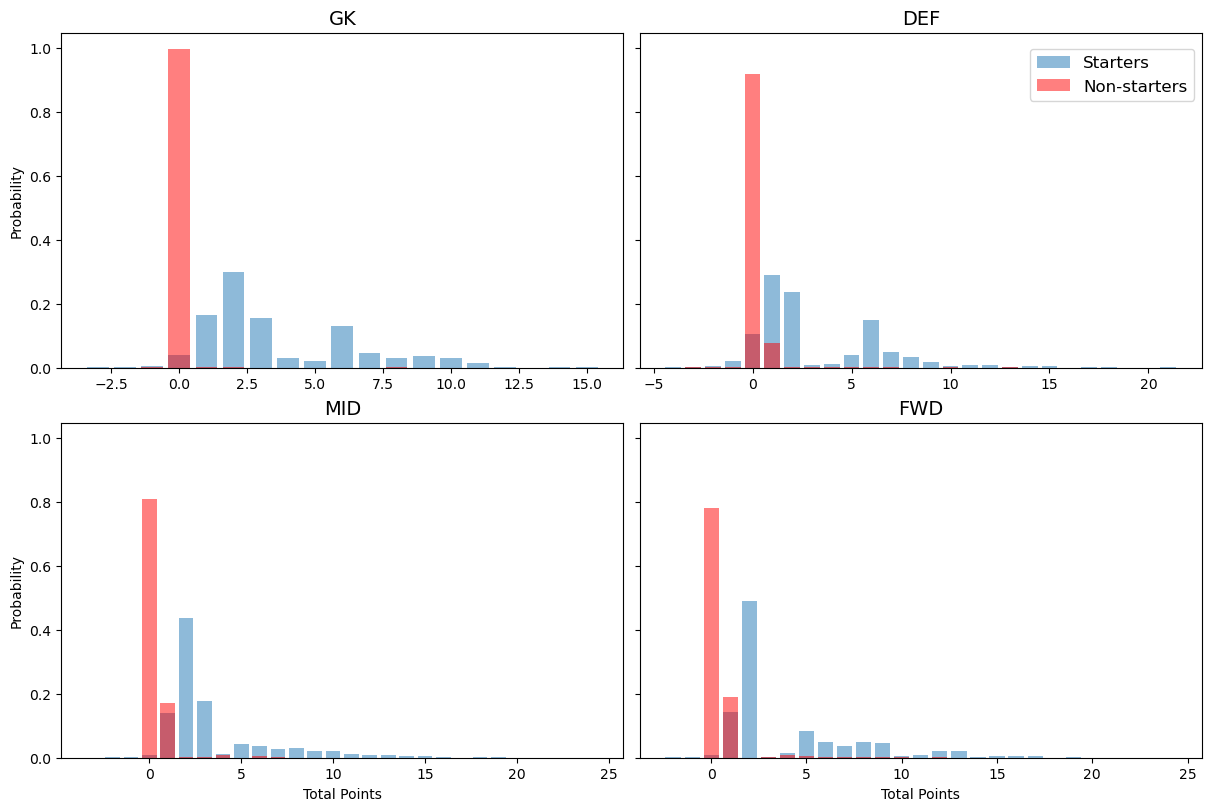

In [4]:
# Create bar plots for returns of starters and non-starters in each position
element_type_dict = {1 : 'GK', 2 : 'DEF', 3 : 'MID', 4 : 'FWD'}

fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharey='all', layout='constrained')
axs = axs.flatten()

for ax, element_type in zip(axs, element_types_list):
    total_points = total_points_dist_dict[element_type]
    ax.bar(total_points['starters'].index, total_points['starters'].values, alpha=0.5, label="Starters")
    ax.bar(total_points['non-starters'].index, total_points['non-starters'].values, alpha=0.5, label="Non-starters", color='r')
    ax.set_title(element_type_dict[element_type], fontsize=14)

axs[0].set_ylabel("Probability")
axs[2].set_xlabel("Total Points")
axs[2].set_ylabel("Probability")
axs[3].set_xlabel("Total Points")

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.85, 0.875), fontsize=12)
plt.show()

For each position the distribution of points for starters and non-starters differs significantly, with players not starting the match scoring fewer points on average. The mean points for players starting and not

In particular, players who do not start the match are more likely to score zero points than those starting the game. Since most players not starting a match are simply scoring zero points, my aim will be to predict the points scored by a player given that they start a match. For this model to aid with player selection in the Fantasy Premier League game, it will then be necessary to estimate the probability that a player does indeed start the upcoming match. This will likely be out of the scope of this project.

| Position | Avg. score of starters | Avg. score of non-starters |
| --- | --- | --- |
| GK | 3.608 | 0.005 |
| DEF | 3.083 | 0.098 |
| MID | 3.442 | 0.266 |
| FWD | 3.927 | 0.344 |
| **Aggregate** | **3.374** | **0.191** |

In [5]:
has_na = fpl_df.isna().any(axis=1).astype(int).value_counts(normalize=True)[1]
print("{:.1f}% of rows contain null values".format(has_na*100))

11.6% of rows contain null values


There are a number of methods for dealing with the null values in the data. Since these have been systematically induced by the lagging process when creating the dataset, I have chosen to drop the rows containing the null values.

In [6]:
# Drop null values and players who did not start from the model dataframe
model_df = fpl_df.copy()
model_df.dropna(inplace=True)
model_df.drop(model_df.loc[model_df.starts == 0].index, axis=0, inplace=True)

There are a couple of ways that I can think to possibly improve the features of the data. The first is to consider the number of incoming/outgoing transfers for a player as a percentage of the total number of incoming/outgoing tranfers for the player's position. To my mind, this should reduce the effect of the varying number of active players across the season on the number of total transfers for a player and give a better indication of how in-demand the player truly is. Another idea is to introduce a new feature which ranks players based on the number of net incoming transfers in the build-up to the gameweek.

In [7]:
# Add new features that require grouping to the model dataframe 
def create_feature_cols(df):
    df1 = df.drop_duplicates(["element"])
    df1['transfers_in_pct'] = 100 * df1.transfers_in/df1.transfers_in.sum()
    df1['transfers_out_pct'] = 100 * df1.transfers_out/df1.transfers_out.sum()
    df1['transfers_balance_rank'] = df1.transfers_balance.rank()
    
    df = df.merge(df1[['element', 'transfers_in_pct', 'transfers_out_pct', 'transfers_balance_rank']],
                  how='left',
                  on='element')
    return df[['element', 'transfers_in_pct', 'transfers_out_pct', 'transfers_balance_rank']]

new_features_df = model_df.groupby(["season_x", "round", "element_type"]).apply(create_feature_cols)

new_features_df.index = new_features_df.index.droplevel(3)
new_features_df.reset_index(inplace=True)

model_df = pd.merge(model_df, new_features_df)
model_df.drop_duplicates(inplace=True)

# Add other features to the dataframe
model_df['delta_value'] = model_df['value'] - model_df['value_1']

In [8]:
# Sort the dataframe by time
model_df.sort_values("kickoff_date", ascending=True)

# Drop columns not to be included in the models
drop_cols = ['assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'element', 'fixture', 'goals_conceded', 'goals_scored', 
             'ict_index', 'influence', 'kickoff_time', 'minutes', 'opponent_team', 'own_goals', 'penalties_missed', 
             'penalties_saved', 'red_cards', 'round', 'saves', 'team_a_score', 'team_h_score', 'threat', 'transfers_balance', 
             'yellow_cards', 'name', 'season_x', 'opp_team_name', 'kickoff_datetime', 'kickoff_date', 'team_x', 'starts', 
             'shots', 'xG', 'position', 'xA', 'key_passes', 'npg', 'npxG', 'xGChain', 'xGBuildup', 'team_xG', 'team_xGA', 
             'team_npxG', 'team_npxGA', 'team_deep', 'team_deep_allowed', 'team_scored', 'team_missed', 'team_xpts', 
             'team_result', 'team_wins', 'team_draws', 'team_loses', 'team_pts', 'team_npxGD', 'team_ppda_att', 
             'team_ppda_def', 'team_ppda_allowed_att', 'team_ppda_allowed_def']

model_df.drop(drop_cols, axis=1, inplace=True)

# Set all remaining columns to be numeric
model_df = model_df.astype(float)

In [9]:
# Split data by position for modelling
gk_df = model_df.loc[model_df.element_type == 1].copy().drop('element_type', axis=1)
def_df = model_df.loc[model_df.element_type == 2].copy().drop('element_type', axis=1)
mid_df = model_df.loc[model_df.element_type == 3].copy().drop('element_type', axis=1)
fwd_df = model_df.loc[model_df.element_type == 4].copy().drop('element_type', axis=1)

# Split each dataframe and response vector into a training set and a test set
X_train_gk, X_test_gk, y_train_gk, y_test_gk = train_test_split(
    gk_df.drop('total_points', axis=1), 
    gk_df['total_points'], 
    test_size=0.2, 
    shuffle=False)

X_train_def, X_test_def, y_train_def, y_test_def = train_test_split(
    def_df.drop('total_points', axis=1), 
    def_df['total_points'], 
    test_size=0.2, 
    shuffle=False)

X_train_mid, X_test_mid, y_train_mid, y_test_mid = train_test_split(
    mid_df.drop('total_points', axis=1), 
    mid_df['total_points'], 
    test_size=0.2, 
    shuffle=False)

X_train_fwd, X_test_fwd, y_train_fwd, y_test_fwd = train_test_split(
    fwd_df.drop('total_points', axis=1), 
    fwd_df['total_points'], 
    test_size=0.2, 
    shuffle=False)

In [10]:
# Function to return normalized design matrices
def normalize(train_df, test_df):    
    X_mean = train_df.mean()
    X_std = train_df.std()
    X_train = ((train_df - X_mean)/X_std)
    X_test = ((test_df - X_mean)/X_std)
    
    # Find columns that have null values in X_train, which correspond to constant columns in train_df, and drop from X_train
    # and X_test
    na_cols = X_train.columns[X_train.isna().any(axis=0)]
    X_train.drop(na_cols, axis=1, inplace=True)
    X_test.drop(na_cols, axis=1, inplace=True)
    
    # Add constant term
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test, has_constant='add')
    
    return X_train, X_test

In [11]:
X_train_gk1, X_test_gk1 = normalize(X_train_gk, X_test_gk)
X_train_def1, X_test_def1 = normalize(X_train_def, X_test_def)
X_train_mid1, X_test_mid1 = normalize(X_train_mid, X_test_mid)
X_train_fwd1, X_test_fwd1 = normalize(X_train_fwd, X_test_fwd)

# 3 Goalkeeper modelling

I begin by examining the correlation between columns in the dataframe. Having highly correlated columns in the dataframe can create numerical instability in the regression estimates. In this context, since several statistics exhibit autocorrelation across various lags, this manifests itself as correlation between columns in the design matrix. In order to establish a parsimonious model, I will remove columns beginning with those further back in time. 

In [12]:
corr_mat = X_train_gk1.corr()

corr_threshold = 0.9
corr_pairs = []
is_corr = (corr_mat >= corr_threshold)
for i in range(is_corr.shape[0]):
    for j in range(i+1, is_corr.shape[1]):
        if is_corr.iloc[i, j]:
            corr_pairs.append(["{}".format(is_corr.index[i]), "{}".format(is_corr.columns[j])])
            
print("There are {} column pairs with correlation greater than {}".format(len(corr_pairs), corr_threshold))

There are 73 column pairs with correlation greater than 0.9


I will avoid showing all pairs of columns exceeding the threshold but the following table gives a snapshot of some of the correlation data:

| Column pair | Correlation |
| --- | --- |
| selected, selected_1 | 0.994 |
| selected, selected_2 | 0.985 |
| selected, selected_3 | 0.975 |
| selected, selected_4 | 0.963 |
| value, value_1 | 0.999 |
| value, value_2 | 0.998 |
| value, value_3 | 0.996 |
| value, value_4 | 0.995 |
| creativity_1, key_passes_1 | 0.965 |
| goals_conceded_1, team_missed_1 | 0.907 |
| ict_index_1, influence_1 | 0.993 |
| ict_index_1, saves_1 | 0.938 |
| influence_1, saves_1 | 0.948 |
| minutes_1, starts_1 | 0.989 |

In [13]:
# Drop highly correlated columns
drop_cols = (["opp_npxGA_{}".format(x) for x in range(1, 5)] +
             ["opp_npxG_{}".format(x) for x in range(1, 5)] + 
             ["team_npxG_{}".format(x) for x in range(1, 5)] + 
             ["team_npxGA_{}".format(x) for x in range(1, 5)] +
             ["selected_{}".format(x) for x in range(1, 5)] + 
             ["value_{}".format(x) for x in range(1, 5)] + 
             ["influence_{}".format(x) for x in range(1, 5)] + 
             ["ict_index_{}".format(x) for x in range(1, 5)] +
             ["creativity_{}".format(x) for x in range(1, 5)] + 
             ["threat_{}".format(x) for x in range(1, 5)] +
             ["xGBuildup_{}".format(x) for x in range(1, 5)] + 
             ["bps_{}".format(x) for x in range(1, 5)] + 
             ["shots_{}".format(x) for x in range(1, 5)] + 
             ["starts_{}".format(x) for x in range(1, 5)] + 
             ["npxG_{}".format(x) for x in range(1, 5)]
            )

X_train_gk2 = X_train_gk1.drop(drop_cols, axis=1)
X_test_gk2 = X_test_gk1.drop(drop_cols, axis=1)

## 3.1 Ordinary Least Squares

In [14]:
# Fit an initial linear model to the training data
ols_model_gk = sm.OLS(y_train_gk, X_train_gk2)
ols_res_gk = ols_model_gk.fit()

In [15]:
ols_gk_resid = ols_res_gk.resid_pearson
ols_gk_fv = ols_res_gk.fittedvalues

From the QQ plot below we see that the standardised residuals do not appear to follow a standard Normal distribution, indicating that the model is misspecified. The plot of standardised residuals appears to indicate heteroskedasticity in the standardised residuals, again violating the assumptions of the linear model.

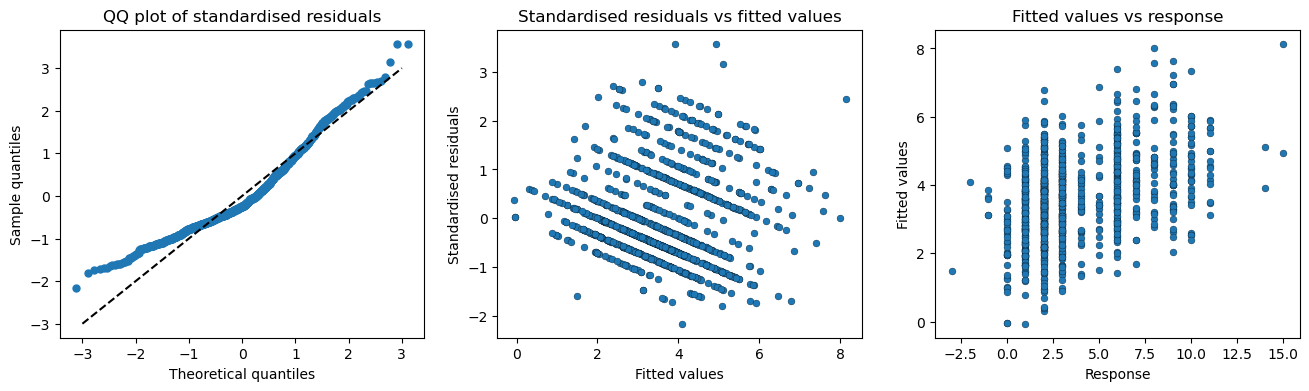

In [16]:
gof_plots(y_train_gk, ols_gk_resid, ols_gk_fv)

I now want to apply the model to the test data in order to assess its performance. As a baseline model I will use the average value from the training data and assign this as the predicted value for all test set data. Then, we can compare the performance of future models against this uninformed model.

In [17]:
# Compute the test MAE and MSE under the use of the training mean as a constant model
gk_baseline_mae = np.mean(abs(y_train_gk.mean() - y_test_gk))
gk_baseline_mse = np.mean((y_train_gk.mean() - y_test_gk)**2)
print("MAE: {:.3f}\nMSE: {:.3f}".format(gk_baseline_mae, gk_baseline_mse))

MAE: 2.446
MSE: 8.432


In [18]:
# Get predicted values for the test data
X_test_gk2 = X_test_gk1[X_train_gk2.columns]
ols_gk_test_predict = ols_res_gk.predict(X_test_gk2)
ols_gk_test_resid = ols_gk_test_predict - y_test_gk

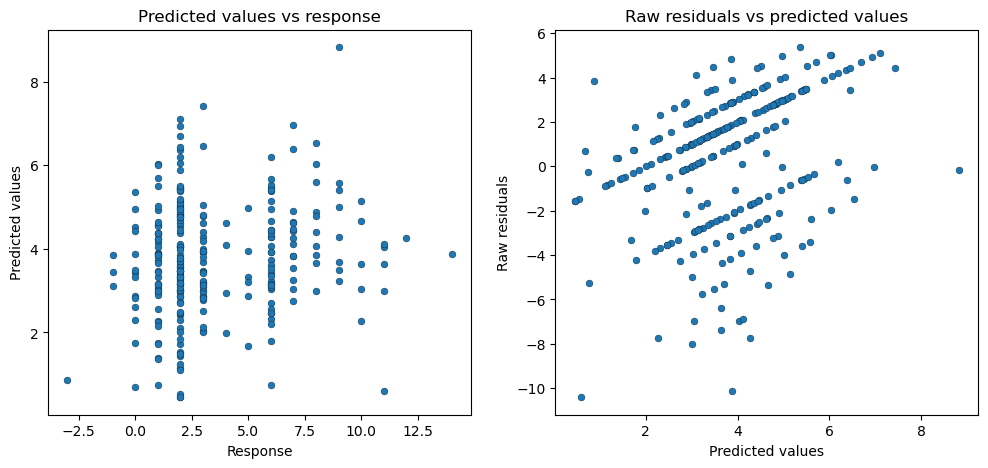

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot of predicted values vs actual values
ax1.scatter(y_test_gk, ols_gk_test_predict, edgecolor='k', linewidths=0.2)
ax1.set_xlabel("Response")
ax1.set_ylabel("Predicted values")
ax1.set_title("Predicted values vs response")

# Plot of residuals vs fitted values
ax2.scatter(ols_gk_test_predict, ols_gk_test_resid, edgecolor='k', linewidths=0.2)
ax2.set_xlabel("Predicted values")
ax2.set_ylabel("Raw residuals")
ax2.set_title("Raw residuals vs predicted values")

plt.show()

In [20]:
# Compute test MAE and MSE
ols_gk_test_mae = np.mean(abs(ols_gk_test_resid))
ols_gk_test_mse = np.mean(ols_gk_test_resid**2)
print("MAE: {:.3f}\nMSE: {:.3f}".format(ols_gk_test_mae, ols_gk_test_mse))

MAE: 2.467
MSE: 9.188


So the initial linear model performs worse on the test set than an uninformed model.

### 3.1.1 Transforming variables

From the diagnostic plots above we can see that the model is misspecified. The QQ plot appears to indicate that the response data is skewed. In order to attempt to resolve this I will apply a Box-Cox transformation to the data. Since the Box-Cox transformation only applies to positive data I will remove the negative observations and, shift the response and apply the Box-Cox transformation to the resulting data. I believe that it is reasonable as negative outcomes constitute only 0.81% of responses across the training and the test data, so the removal of these observations from the training set should have little effect on the overall model.

In [21]:
shift = 1
y_train_gk_boxcox = y_train_gk.drop(y_train_gk.loc[y_train_gk < 0].index) + shift
y_train_gk_boxcox_index = y_train_gk_boxcox.index
X_train_gk_boxcox = X_train_gk2.drop(y_train_gk.loc[y_train_gk < 0].index)

y_train_gk_boxcox, lambda_gk = stats.boxcox(y_train_gk_boxcox)

y_train_gk_boxcox = pd.Series(y_train_gk_boxcox, y_train_gk_boxcox_index)

In [22]:
# Perform stepwise backward elimination, removing variables whose coefficient estimates do not have p-values falling below
# the specified threshold
priority_list_gk = priority_list.copy()
dropped_cols = []
X_train_gk_temp = X_train_gk_boxcox.copy()
selection_complete = False
p_value_threshold = 0.1

while not selection_complete:
    model_temp = sm.OLS(y_train_gk_boxcox, X_train_gk_temp)
    res_temp = model_temp.fit()
    drop_candidates = res_temp.pvalues.loc[res_temp.pvalues > p_value_threshold]
    if len(drop_candidates) == 0:
        selection_complete = True
        continue
    
    drop_col = priority_list_gk.pop([col in drop_candidates for col in priority_list_gk].index(True))
    dropped_cols.append(drop_col)
    X_train_gk_temp.drop(drop_col, axis=1, inplace=True)

In [23]:
[x for x in X_train_fwd.columns if x not in priority_list]

[]

In [24]:
# Examine model chosen by backward elimination
X_train_gk_bs = sm.add_constant(X_train_gk_temp)
ols_bs_model_gk = sm.OLS(y_train_gk_boxcox, X_train_gk_bs)
ols_bs_res_gk = ols_bs_model_gk.fit()

print(ols_bs_res_gk.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     7.936
Date:                Sat, 13 Apr 2024   Prob (F-statistic):           2.39e-14
Time:                        01:38:58   Log-Likelihood:                -875.80
No. Observations:                1073   AIC:                             1778.
Df Residuals:                    1060   BIC:                             1842.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

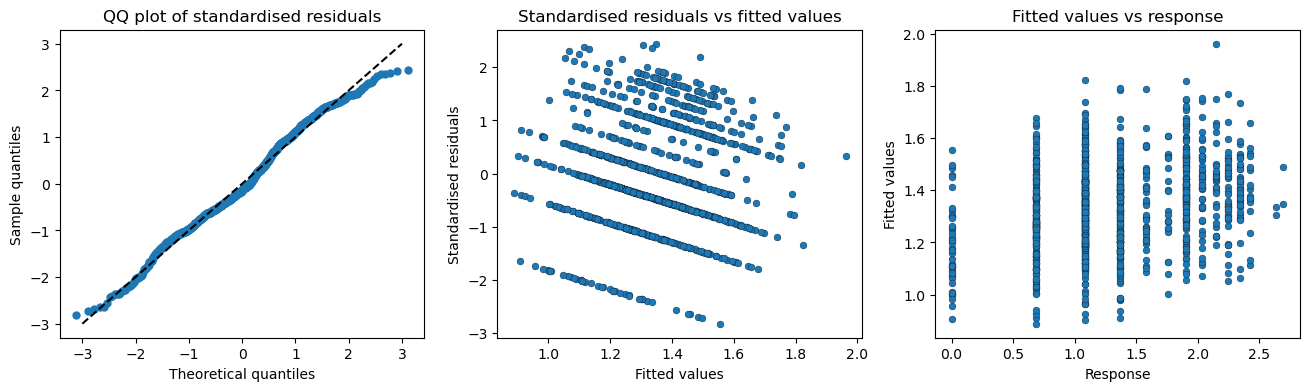

In [25]:
ols_bs_gk_resid = ols_bs_res_gk.resid_pearson
ols_bs_gk_fv = ols_bs_res_gk.fittedvalues

gof_plots(y_train_gk_boxcox, ols_bs_gk_resid, ols_bs_gk_fv)

The above diagnostic plots show that there has been an improvement in the specification of the model as a result of the transformation of the response variable and the application of the backward elimination variable selection process. The QQ plot indicates that the standardised residuals more closely fit the standard normal distribution; the plot of standardised residuals vs fitted values shows a decrease in clear heteroskedasticity in the residuals; and, although the fitted values vs response plot shows an increase in variablility, this is likely due to overfitting in the previous model.

In [26]:
# Define a function to perform an inverse Box-Cox transformation
def inverse_boxcox(x, lmbda):
    if lmbda == 0:
        return(np.exp(x))
    
    else:
        return((x*lmbda + 1)**(1/lmbda))

In [27]:
# Apply the backward selection model to the test data
X_test_gk_bs = X_test_gk1[X_train_gk_bs.columns]

# Apply inverse Box-Cox transformation to the predicted values
ols_bs_gk_test_predict_boxcox = ols_bs_res_gk.predict(X_test_gk_bs)
ols_bs_gk_test_predict = inverse_boxcox(ols_bs_gk_test_predict_boxcox, lmbda=lambda_gk) - 1

ols_bs_gk_test_resid = ols_bs_gk_test_predict - y_test_gk

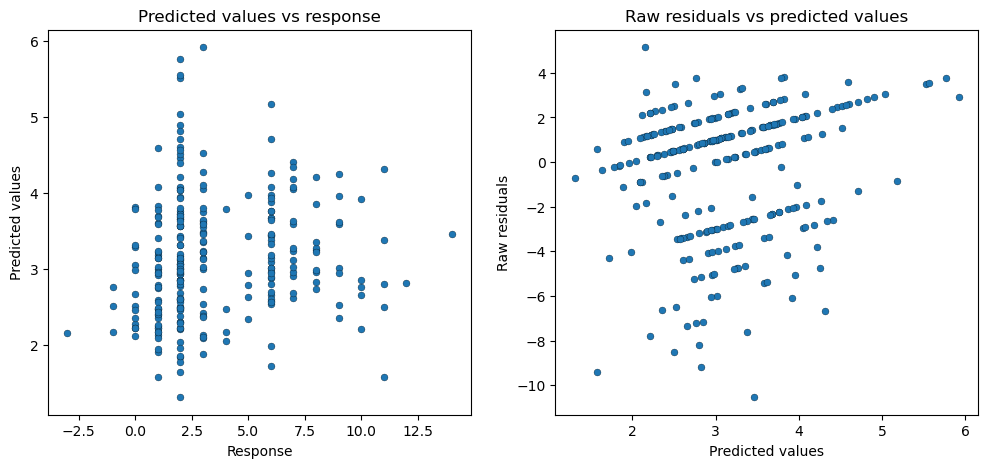

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot of predicted values vs actual values
ax1.scatter(y_test_gk, ols_bs_gk_test_predict, edgecolor='k', linewidths=0.2)
ax1.set_xlabel("Response")
ax1.set_ylabel("Predicted values")
ax1.set_title("Predicted values vs response")

# Plot of residuals vs fitted values
ax2.scatter(ols_bs_gk_test_predict, ols_bs_gk_test_resid, edgecolor='k', linewidths=0.2)
ax2.set_xlabel("Predicted values")
ax2.set_ylabel("Raw residuals")
ax2.set_title("Raw residuals vs predicted values")

plt.show()

In [29]:
# Compute OOS MAE and MSE
mae_bs = np.mean(abs(ols_bs_gk_test_resid))
mse_bs = np.mean(ols_bs_gk_test_resid**2)
print("MAE: {:.3f}\nMSE: {:.3f}".format(mae_bs, mse_bs))

MAE: 2.291
MSE: 8.657


## 3.2 Lasso Regression

We now move on to fitting penalised regressions in order to select important variables. We begin by performing a cross-validation to determine the optimal order of magnitude for the penalisation parameter. For both the lasso and ridge regressions we continue to fit the linear model to the response after having applied the Box-Cox transform as above.

In [30]:
# Run a lasso regression implementing 10-fold cross-validation for the selection of the tuning parameter
validation_idxs = split(X_train_gk_boxcox.sample(frac=1).index, 10)
lasso_gk_alpha_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
lasso_gk_cv_error_dict = {'mae': [], 'mse': []}
for a in lasso_gk_alpha_list:
    mae = []
    mse = []
    
    for i, idx in enumerate(validation_idxs):
        X_val_gk_cv = X_train_gk_boxcox.loc[idx]
        y_val_gk_cv = y_train_gk[idx]
        X_train_gk_cv = X_train_gk_boxcox.drop(idx, axis=0)
        y_train_gk_cv = y_train_gk_boxcox.drop(idx)
        
        lasso_gk_model = sm.OLS(y_train_gk_cv, X_train_gk_cv)
        lasso_gk_res = lasso_gk_model.fit_regularized(alpha=a, L1_wt=1)
        
        lasso_gk_cv_predict_boxcox = lasso_gk_res.predict(X_val_gk_cv)
        lasso_gk_cv_predict = inverse_boxcox(lasso_gk_cv_predict_boxcox, lmbda=lambda_gk) - 1
        
        mae.append(np.mean(abs(lasso_gk_cv_predict - y_val_gk_cv)))
        mse.append(np.mean((lasso_gk_cv_predict - y_val_gk_cv)**2))
        
    lasso_gk_cv_error_dict['mae'].append(np.mean(mae))
    lasso_gk_cv_error_dict['mse'].append(np.mean(mse))

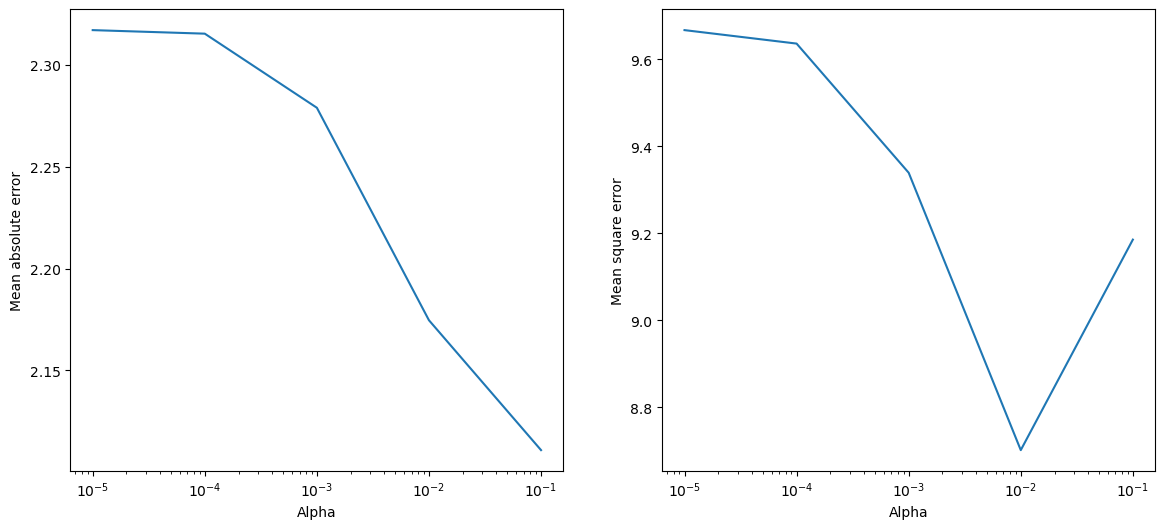

In [31]:
# Plot the MAE and MSE for different values of the tuning parameters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(lasso_gk_alpha_list, lasso_gk_cv_error_dict['mae'])
ax1.set_xscale("log")
ax1.set_xlabel("Alpha")
ax1.set_ylabel("Mean absolute error")

ax2.plot(lasso_gk_alpha_list, lasso_gk_cv_error_dict['mse'])
ax2.set_xscale("log")
ax2.set_xlabel("Alpha")
ax2.set_ylabel("Mean square error")

plt.show()

The plots above indicate that the best two options for the penalisation parameter, `alpha`, would be 0.1, which minimizes the mean absolute error, or 0.01, which minimizes the mean square error. Note that, here, the larger the size of the parameter the stricter the penalisation of the regression coefficients. I have chosen to use `alpha` = 0.01 as the minimizer of the mean square error on the validation sets.

In [32]:
# Fit the final lasso model
lasso_gk_alpha = 1e-2

lasso_gk_model = sm.OLS(y_train_gk_boxcox, X_train_gk_boxcox)
lasso_gk_res = lasso_gk_model.fit_regularized(alpha=lasso_gk_alpha, L1_wt=1)

In [33]:
# Predict the response on the test set
lasso_gk_test_predict_boxcox = lasso_gk_res.predict(X_test_gk2)
lasso_gk_test_predict = inverse_boxcox(lasso_gk_test_predict_boxcox, lmbda=lambda_gk)
lasso_gk_test_resid = lasso_gk_test_predict - y_test_gk

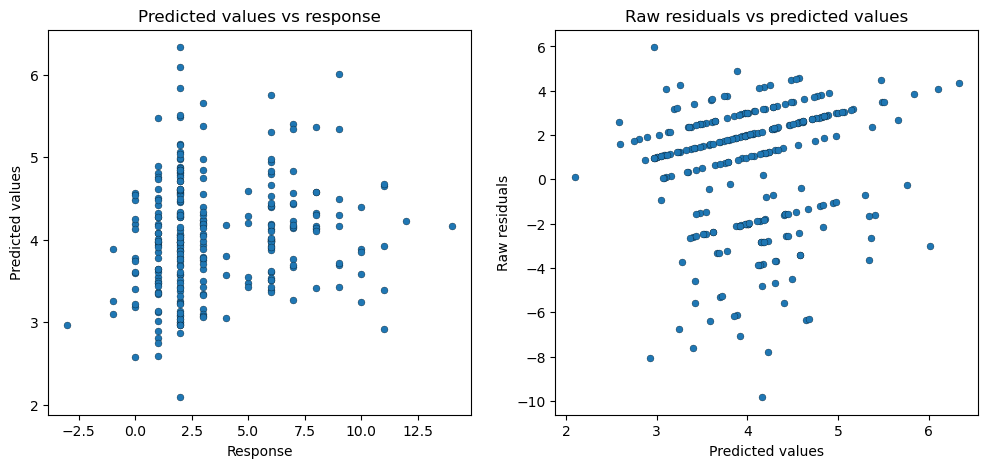

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot of predicted values vs actual values
ax1.scatter(y_test_gk, lasso_gk_test_predict, edgecolor='k', linewidths=0.2)
ax1.set_xlabel("Response")
ax1.set_ylabel("Predicted values")
ax1.set_title("Predicted values vs response")

# Plot of residuals vs fitted values
ax2.scatter(lasso_gk_test_predict, lasso_gk_test_resid, edgecolor='k', linewidths=0.2)
ax2.set_xlabel("Predicted values")
ax2.set_ylabel("Raw residuals")
ax2.set_title("Raw residuals vs predicted values")

plt.show()

In [35]:
# Compute OOS MAE and MSE
lasso_gk_mae = np.mean(abs(lasso_gk_test_resid))
lasso_gk_mse = np.mean(lasso_gk_test_resid**2)
print("MAE: {:.3f}\nMSE: {:.3f}".format(lasso_gk_mae, lasso_gk_mse))

MAE: 2.522
MSE: 8.590


## 3.3 Ridge Regression

In [36]:
# Run a ridge regression implementing 10-fold cross-validation for the selection of the tuning parameter
ridge_gk_alpha_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
ridge_gk_cv_error_dict = {'mae': [], 'mse': []}
for a in ridge_gk_alpha_list:
    mae = []
    mse = []
    
    for i, idx in enumerate(validation_idxs):
        X_val_gk_cv = X_train_gk_boxcox.loc[idx]
        y_val_gk_cv = y_train_gk[idx]
        X_train_gk_cv = X_train_gk_boxcox.drop(idx, axis=0)
        y_train_gk_cv = y_train_gk_boxcox.drop(idx)
        
        ridge_gk_model = sm.OLS(y_train_gk_cv, X_train_gk_cv)
        ridge_gk_res = ridge_gk_model.fit_regularized(alpha=a, L1_wt=0)
        
        ridge_gk_cv_predict_boxcox = ridge_gk_res.predict(X_val_gk_cv)
        ridge_gk_cv_predict = inverse_boxcox(ridge_gk_cv_predict_boxcox, lmbda=lambda_gk) - 1
        
        mae.append(np.mean(abs(ridge_gk_cv_predict - y_val_gk_cv)))
        mse.append(np.mean((ridge_gk_cv_predict - y_val_gk_cv)**2))
        
    ridge_gk_cv_error_dict['mae'].append(np.mean(mae))
    ridge_gk_cv_error_dict['mse'].append(np.mean(mse))

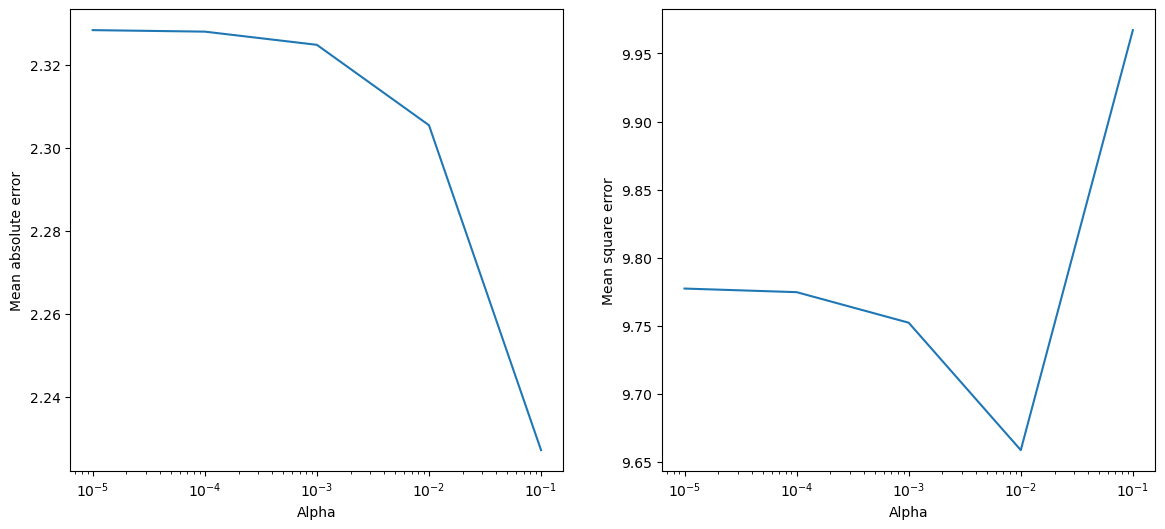

In [37]:
# Plot the MAE and MSE on the validation sets for different values of the tuning parameters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(ridge_gk_alpha_list, ridge_gk_cv_error_dict['mae'])
ax1.set_xscale("log")
ax1.set_xlabel("Alpha")
ax1.set_ylabel("Mean absolute error")

ax2.plot(ridge_gk_alpha_list, ridge_gk_cv_error_dict['mse'])
ax2.set_xscale("log")
ax2.set_xlabel("Alpha")
ax2.set_ylabel("Mean square error")

plt.show()

In [153]:
# Fit the final ridge model
ridge_gk_alpha = 1e-2

ridge_gk_model = sm.OLS(y_train_gk_boxcox, X_train_gk_boxcox)
ridge_gk_res = ridge_gk_model.fit_regularized(alpha=ridge_gk_alpha, L1_wt=0)

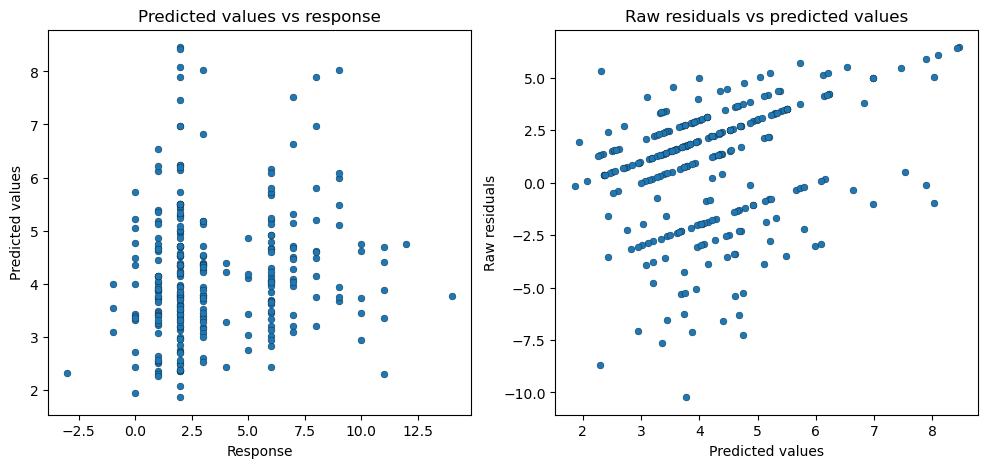

In [154]:
# Predict the response on the test set
ridge_gk_test_predict_boxcox = ridge_gk_res.predict(X_test_gk2)
ridge_gk_test_predict = inverse_boxcox(ridge_gk_test_predict_boxcox, lmbda=lambda_gk)
ridge_gk_test_resid = ridge_gk_test_predict - y_test_gk

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot of predicted values vs actual values
ax1.scatter(y_test_gk, ridge_gk_test_predict, edgecolor='k', linewidths=0.2)
ax1.set_xlabel("Response")
ax1.set_ylabel("Predicted values")
ax1.set_title("Predicted values vs response")

# Plot of residuals vs fitted values
ax2.scatter(ridge_gk_test_predict, ridge_gk_test_resid, edgecolor='k', linewidths=0.2)
ax2.set_xlabel("Predicted values")
ax2.set_ylabel("Raw residuals")
ax2.set_title("Raw residuals vs predicted values")

plt.show()

In [155]:
# Compute OOS MAE and MSE
ridge_gk_mae = np.mean(abs(ridge_gk_test_resid))
ridge_gk_mse = np.mean(ridge_gk_test_resid**2)
print("MAE: {:.3f}\nMSE: {:.3f}".format(ridge_gk_mae, ridge_gk_mse))

MAE: 2.557
MSE: 9.509


## 3.4 Random Forest Regression

In [41]:
# Conduct 10-fold cross-validation on the parameter grid to select hyperparameters for the random forest
rf_gk_param_grid = {'max_depth': [1, 2, 3, 4, 5, 6, 10],
                    'n_estimators': [50, 100, 200, 500, 1000],
                    'max_features': [None, 'log2', 'sqrt']}
scoring_metrics = ['neg_mean_absolute_error', 'neg_mean_squared_error']
rf_gk_cv_results = GridSearchCV(RandomForestRegressor(), 
                                rf_gk_param_grid, 
                                scoring=scoring_metrics,
                                cv=10,
                                refit=False)
rf_gk_cv_results.fit(X_train_gk1, y_train_gk)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 10],
                         'max_features': [None, 'log2', 'sqrt'],
                         'n_estimators': [50, 100, 200, 500, 1000]},
             refit=False,
             scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'])

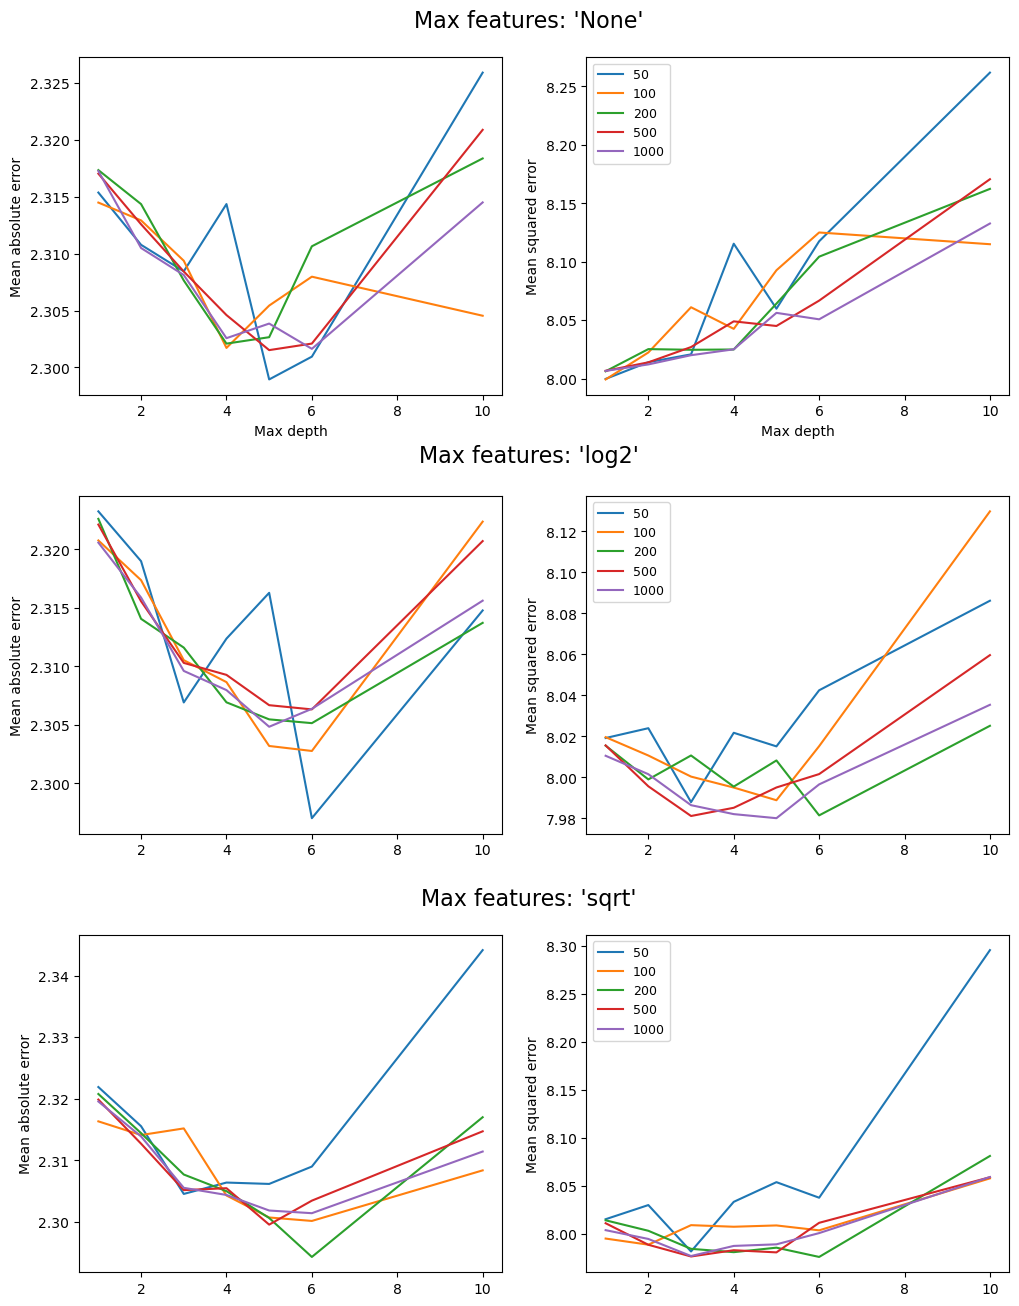

In [160]:
cv_results = rf_gk_cv_results.cv_results_

fig, axs = plt.subplots(3, 2, figsize=(12, 15))
fig.subplots_adjust(hspace=0.3, top=0.92)

for i, max_features in enumerate(rf_gk_param_grid['max_features']):
    for n in rf_gk_param_grid['n_estimators']:
        data_idx_bool = ((cv_results['param_max_features'] == max_features) & (cv_results['param_n_estimators'] == n))
        depth_data = cv_results['param_max_depth'][data_idx_bool]
        
        mae_data = -1*cv_results['mean_test_neg_mean_absolute_error'][data_idx_bool]
        # mae_error_data = cv_results['std_test_neg_mean_absolute_error'][data_idx_bool]
        
        mse_data = -1*cv_results['mean_test_neg_mean_squared_error'][data_idx_bool]
        # mse_error_data = cv_results['std_test_neg_mean_squared_error'][data_idx_bool]
        
        axs[i, 0].plot(depth_data, mae_data, label=f"{n}")
        axs[i, 1].plot(depth_data, mse_data, label=f"{n}")
        
        axs[i, 0].set_ylabel("Mean absolute error")
        axs[i, 1].set_ylabel("Mean squared error")
    
axs[0, 0].set_xlabel("Max depth")
axs[0, 1].set_xlabel("Max depth")

# Add title and subtitles to figure
fig.text(0.5, 0.94, 
         f"Max features: '{rf_gk_param_grid['max_features'][0]}'", 
         fontsize=16, 
         horizontalalignment='center')
fig.text(0.5, 0.65, 
         f"Max features: '{rf_gk_param_grid['max_features'][1]}'", 
         fontsize=16, 
         horizontalalignment='center')
fig.text(0.5, 0.355, 
         f"Max features: '{rf_gk_param_grid['max_features'][2]}'", 
         fontsize=16, 
         horizontalalignment='center')

# Add legends to axes
axs[0, 1].legend(fontsize=9)
axs[1, 1].legend(fontsize=9)
axs[2, 1].legend(fontsize=9)

plt.show()

In [ ]:
# Plot the standard deviations of the validation error metrics
cv_results = rf_gk_cv_results.cv_results_

fig, axs = plt.subplots(3, 2, figsize=(12, 15))
fig.subplots_adjust(hspace=0.3, top=0.92)

for i, max_features in enumerate(rf_gk_param_grid['max_features']):
    for n in rf_gk_param_grid['n_estimators']:
        data_idx_bool = ((cv_results['param_max_features'] == max_features) & (cv_results['param_n_estimators'] == n))
        depth_data = cv_results['param_max_depth'][data_idx_bool]
        
        mae_data = -1*cv_results['mean_test_neg_mean_absolute_error'][data_idx_bool]
        # mae_error_data = cv_results['std_test_neg_mean_absolute_error'][data_idx_bool]
        
        mse_data = -1*cv_results['mean_test_neg_mean_squared_error'][data_idx_bool]
        # mse_error_data = cv_results['std_test_neg_mean_squared_error'][data_idx_bool]
        
        axs[i, 0].plot(depth_data, mae_data, label=f"{n}")
        axs[i, 1].plot(depth_data, mse_data, label=f"{n}")
        
        axs[i, 0].set_ylabel("Mean absolute error")
        axs[i, 1].set_ylabel("Mean squared error")
    
axs[0, 0].set_xlabel("Max depth")
axs[0, 1].set_xlabel("Max depth")

# Add title and subtitles to figure
fig.text(0.5, 0.94, 
         f"Max features: '{rf_gk_param_grid['max_features'][0]}'", 
         fontsize=16, 
         horizontalalignment='center')
fig.text(0.5, 0.65, 
         f"Max features: '{rf_gk_param_grid['max_features'][1]}'", 
         fontsize=16, 
         horizontalalignment='center')
fig.text(0.5, 0.355, 
         f"Max features: '{rf_gk_param_grid['max_features'][2]}'", 
         fontsize=16, 
         horizontalalignment='center')

# Add legends to axes
axs[0, 1].legend(fontsize=9)
axs[1, 1].legend(fontsize=9)
axs[2, 1].legend(fontsize=9)

plt.show()

In [44]:
# # Fit the random forest regression model with hyperparameters as determined above
# max_depth_final = 4
# n_estimators_final = 1000
# rf_gk_model1 = RandomForestRegressor(max_depth=max_depth_final, random_state=0, oob_score=True, n_estimators=n_estimators_final)
# rf_gk_model1.fit(X_train_gk1, y_train_gk)

# rf1_gk_predict_train = rf_gk_model1.predict(X_train_gk1)
# rf1_gk_predict_test = rf_gk_model1.predict(X_test_gk1)

# rf1_gk_resid_train = rf1_gk_predict_train - y_train_gk
# rf1_gk_resid_test = rf1_gk_predict_test - y_test_gk

# rf1_gk_train_mae = np.mean(abs(resid_train))
# rf1_gk_test_mae = np.mean(abs(resid_test))
# rf1_gk_train_mse = np.mean(resid_train**2)
# rf1_gk_test_mse = np.mean(resid_test**2)

# print("MAE on test set = {}\nMSE on test set = {}".format(rf1_gk_test_mae, rf1_gk_test_mse))

In [45]:
# # Examine feature importance
# feature_importances = (pd.Series(rf_gk_model1.feature_importances_, index=X_train_gk1.columns)
#                        .sort_values()
#                        .to_frame(name='importance'))
# feature_importances['rank'] = feature_importances.importance.rank(ascending=False)
# fig, ax = plt.subplots(figsize=(8, 52))
# ax.margins(y = 0.0025)
# ax.barh(feature_importances.index, feature_importances.importance)
# plt.show()

In [46]:
# importance_threshold = 0.005
# rf_vars_initial = feature_importances.loc[feature_importances.importance >= importance_threshold].index.tolist()
# n_vars = len(rf_vars_initial)
# print("No. of variables = {}".format(len(feature_importances)))
# print("No. of variables above importance threshold = {}".format(len(rf_vars_initial)))

In [47]:
# # We will only perform the variable selection CV using variables that are above the importance threshold in the initial model
# # since running this for all variables would be time-consuming although theoretically preferred.

# # Set up the variable selection cross-validation
# validation_sets = split(X_train_gk1.index, 10)
# max_depth = 4
# n_estimators_list = [1000]
# cv_info = {n: {} for n in n_estimators_list}

# for n_estimators in n_estimators_list:
#     Z_train = X_train_gk1[rf_vars_initial]
#     Z_test = X_test_gk1[rf_vars_initial]
#     rf_vars_current = rf_vars_initial.copy()
#     cv_info[n_estimators] = {x: {} for x in range(1, len(rf_vars_initial)+1)}

#     while len(rf_vars_current) > 0: 
#         print(len(rf_vars_current))
#         cv_info[n_estimators][len(rf_vars_current)]['vars'] = rf_vars_current.copy()

#         Z_train = Z_train[rf_vars_current]
#         rf_regr_vs = RandomForestRegressor(max_depth=max_depth,
#                                             random_state=0,
#                                             oob_score=True,
#                                             n_estimators=n_estimators)
#         rf_regr_vs.fit(Z_train, y_train_gk)

#         # Get MAE and MSE estimates using cross-validation
#         mae = []
#         mse = []
#         for validation_idxs in validation_sets:
#             Z_train1 = Z_train.drop(validation_idxs, axis=0)
#             y_train_gk1 = y_train_gk.drop(validation_idxs)
#             Z_val = Z_train.loc[validation_idxs]
#             y_val_gk = y_train_gk.loc[validation_idxs]

#             rf_regr = RandomForestRegressor(max_depth=max_depth,
#                                             random_state=0,
#                                             oob_score=True,
#                                             n_estimators=n_estimators)
#             rf_regr.fit(Z_train1, y_train_gk1)

#             predict_val = rf_regr.predict(Z_val)
#             resid_val = predict_val - y_val_gk
#             mae.append(np.mean(abs(resid_val)))
#             mse.append(np.mean(resid_val**2))

#         cv_info[n_estimators][len(rf_vars_current)]['mae'] = np.mean(mae)
#         cv_info[n_estimators][len(rf_vars_current)]['mse'] = np.mean(mse)

#         var_importances = pd.Series(rf_regr_vs.feature_importances_, index=rf_vars_current).sort_values()
#         drop_var = var_importances.index[0]
#         rf_vars_current.remove(var_importances.index[0])

    

In [48]:
# idx = np.linspace(1, n_vars, n_vars)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# for n_estimators in n_estimators_list:
#     mae_varselect_cv = [cv_info[n_estimators][x]['mae'] for x in cv_info[n_estimators]]
#     mse_varselect_cv = [cv_info[n_estimators][x]['mse'] for x in cv_info[n_estimators]]
    
#     ax1.plot(idx, mae_varselect_cv, label="{}".format(n_estimators))
#     ax2.plot(idx, mse_varselect_cv, label="{}".format(n_estimators))
    
# ax1.set_xlabel("No. of variables")
# ax1.set_ylabel("Validation MAE")
# ax1.legend()
# ax2.set_xlabel("No. of variables")
# ax2.set_ylabel("Validation MSE")
# ax2.legend()

# plt.show()

In [49]:
# # Fit the model after selecting variables
# n_estimators_final = 1000
# n_vars_final = 22
# gk_rf_vars_final = cv_info[n_estimators_final][n_vars_final]['vars']
# X_train_gk_rf = X_train_gk1[gk_rf_vars_final]
# X_test_gk_rf = X_test_gk1[gk_rf_vars_final]

# rf_gk_model2 = RandomForestRegressor(max_depth=4, oob_score=True, n_estimators=n_estimators_final)
# rf_gk_model2.fit(X_train_gk_rf, y_train_gk)

# rf2_gk_test_predict = rf_gk_model2.predict(X_test_gk_rf)
# rf2_gk_test_resid = rf2_gk_test_predict - y_test_gk
# rf2_gk_test_mae = np.mean(abs(rf2_gk_test_resid))
# rf2_gk_test_mse = np.mean(rf2_gk_test_resid**2)
# print("MAE on test set = {:.3f}\nMSE on test set = {:.3f}".format(rf2_gk_test_mae, rf2_gk_test_mse))

# 4 Defender modelling

The process for modelling the points scored by defenders will be the same as for the goalkeepers. In order to avoid labouring points, I will mostly go through the process with little explanation, commenting only where instructive.

In [50]:
# Drop highly correlated columns
drop_cols = (["opp_npxGA_{}".format(x) for x in range(1, 5)] +
             ["opp_npxG_{}".format(x) for x in range(1, 5)] + 
             ["team_npxG_{}".format(x) for x in range(1, 5)] + 
             ["team_npxGA_{}".format(x) for x in range(1, 5)] +
             ["selected_{}".format(x) for x in range(1, 5)] + 
             ["value_{}".format(x) for x in range(1, 5)] + 
             ["creativity_{}".format(x) for x in range(1, 5)] + 
             ["xGBuildup_{}".format(x) for x in range(1, 5)] + 
             ["npxG_{}".format(x) for x in range(1, 5)] + 
             ["npg_{}".format(x) for x in range(1, 5)] + 
             ["starts_{}".format(x) for x in range(1, 5)] + 
             ["bps_{}".format(x) for x in range(1, 5)]
            )

X_train_def2 = X_train_def1.drop(drop_cols, axis=1)
X_test_def2 = X_test_def1.drop(drop_cols, axis=1)

## 4.1 Ordinary Least Squares

In [52]:
# Fit an initial linear model to the training data
ols_model_def = sm.OLS(y_train_def, X_train_def2)
ols_res_def = ols_model_def.fit()

ols_def_resid = ols_res_def.resid_pearson
ols_def_fv = ols_res_def.fittedvalues

The QQ plot of standardised residuals vs the theoretical quantiles appears to show significant skew in the distribution of residuals. Much like the plot for the goalkeepers, the plot of standardised residuals appears to indicate heteroskedasticity in the standardised residuals, with smaller variance in residuals for lower fitted values.

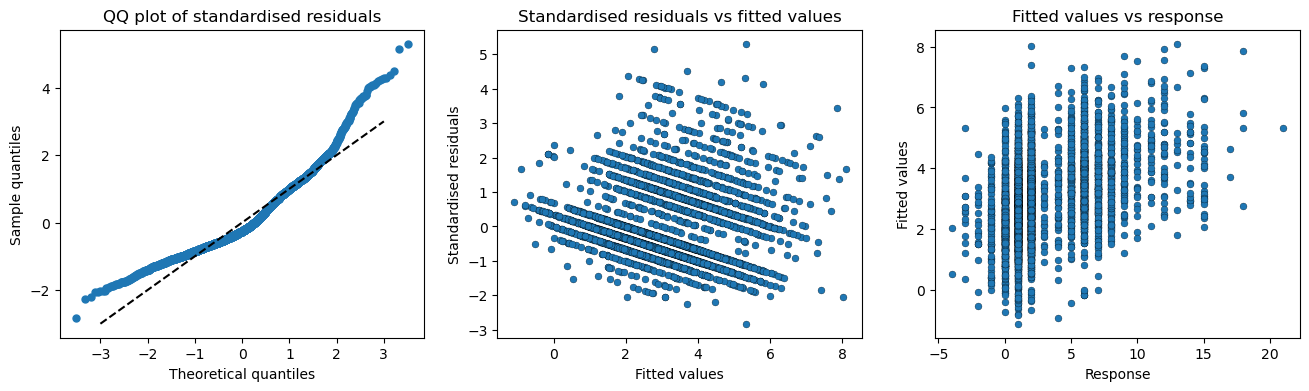

In [53]:
gof_plots(y_train_def, ols_def_resid, ols_def_fv)

I now want to apply the model to the test data in order to assess its performance. As a baseline model I will use the average value from the training data and assign this as the predicted value for all test set data. Then, we can compare the performance of future models against this uninformed model.

In [54]:
# Compute the test MAE and MSE under the use of the training mean as a constant model
def_baseline_mae = np.mean(abs(y_train_def.mean() - y_test_def))
def_baseline_mse = np.mean((y_train_def.mean() - y_test_def)**2)
print("MAE: {:.3f}\nMSE: {:.3f}".format(def_baseline_mae, def_baseline_mse))

MAE: 2.566
MSE: 9.352


In [55]:
# Get predicted values for the test data
X_test_def2 = X_test_def1[X_train_def2.columns]
ols_def_test_predict = ols_res_def.predict(X_test_def2)
ols_def_test_resid = ols_def_test_predict - y_test_def

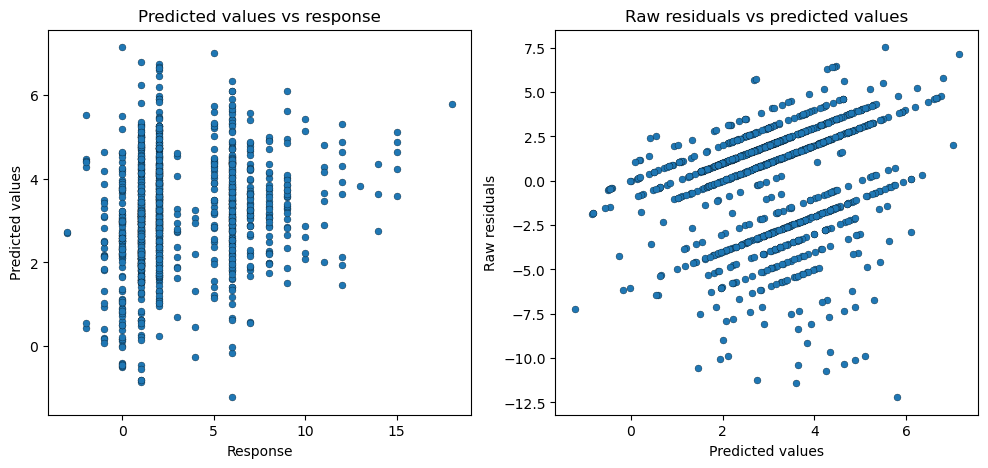

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot of predicted values vs actual values
ax1.scatter(y_test_def, ols_def_test_predict, edgecolor='k', linewidths=0.2)
ax1.set_xlabel("Response")
ax1.set_ylabel("Predicted values")
ax1.set_title("Predicted values vs response")

# Plot of residuals vs fitted values
ax2.scatter(ols_def_test_predict, ols_def_test_resid, edgecolor='k', linewidths=0.2)
ax2.set_xlabel("Predicted values")
ax2.set_ylabel("Raw residuals")
ax2.set_title("Raw residuals vs predicted values")

plt.show()

In [57]:
# Compute test MAE and MSE
ols_def_test_mae = np.mean(abs(ols_def_test_resid))
ols_def_test_mse = np.mean(ols_def_test_resid**2)
print("MAE: {:.3f}\nMSE: {:.3f}".format(ols_def_test_mae, ols_def_test_mse))

MAE: 2.476
MSE: 9.351


In [58]:
shift = 1
y_train_def_boxcox = y_train_def.drop(y_train_def.loc[y_train_def < 0].index) + shift
y_train_def_boxcox_index = y_train_def_boxcox.index
X_train_def_boxcox = X_train_def2.drop(y_train_def.loc[y_train_def < 0].index)

y_train_def_boxcox, lambda_def = stats.boxcox(y_train_def_boxcox)

y_train_def_boxcox = pd.Series(y_train_def_boxcox, y_train_def_boxcox_index)

In [59]:
# Perform stepwise backward elimination, removing variables whose coefficient estimates do not have p-values falling below
# the specified threshold
priority_list_def = priority_list.copy()
dropped_cols = []
X_train_def_temp = X_train_def_boxcox.copy()
selection_complete = False
p_value_threshold = 0.1

while not selection_complete:
    model_temp = sm.OLS(y_train_def_boxcox, X_train_def_temp)
    res_temp = model_temp.fit()
    drop_candidates = res_temp.pvalues.loc[res_temp.pvalues > p_value_threshold]
    if len(drop_candidates) == 0:
        selection_complete = True
        continue
    
    drop_col = priority_list_def.pop([col in drop_candidates for col in priority_list_def].index(True))
    dropped_cols.append(drop_col)
    X_train_def_temp.drop(drop_col, axis=1, inplace=True)

In [60]:
# Examine model chosen by backward elimination
X_train_def_bs = sm.add_constant(X_train_def_temp)
ols_bs_model_def = sm.OLS(y_train_def_boxcox, X_train_def_bs)
ols_bs_res_def = ols_bs_model_def.fit()

print(ols_bs_res_def.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     17.27
Date:                Sat, 13 Apr 2024   Prob (F-statistic):          2.20e-124
Time:                        03:10:03   Log-Likelihood:                -3652.3
No. Observations:                4332   AIC:                             7399.
Df Residuals:                    4285   BIC:                             7698.
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

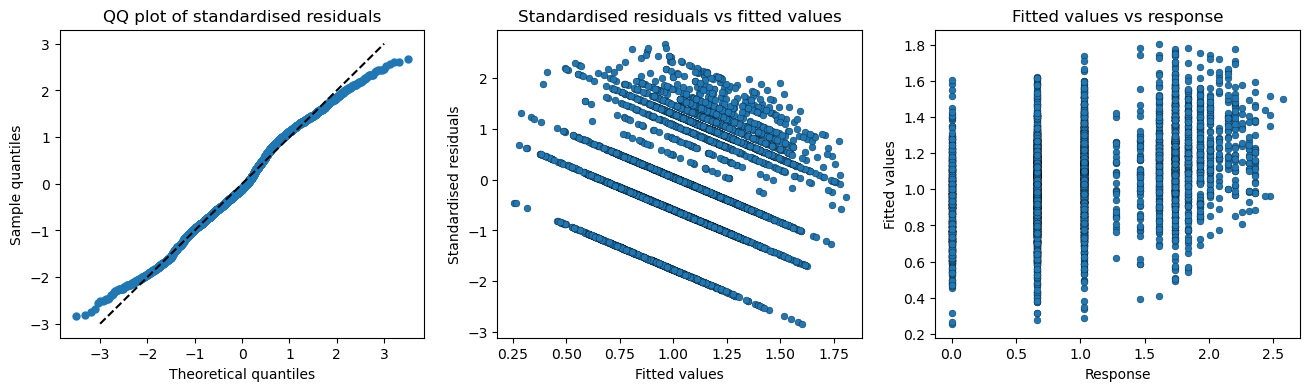

In [61]:
ols_bs_def_resid = ols_bs_res_def.resid_pearson
ols_bs_def_fv = ols_bs_res_def.fittedvalues

gof_plots(y_train_def_boxcox, ols_bs_def_resid, ols_bs_def_fv)

The above diagnostic plots show that there has been an improvement in the specification of the model as a result of the transformation of the response variable and the application of the backward elimination variable selection process. The QQ plot indicates that the standardised residuals more closely fit the standard normal distribution; the plot of standardised residuals vs fitted values shows a decrease in clear heteroskedasticity in the residuals; and, although the fitted values vs response plot shows an increase in variablility, this is likely due to overfitting in the previous model.

In [62]:
# Apply the backward selection model to the test data
X_test_def_bs = X_test_def1[X_train_def_bs.columns]

# Apply inverse Box-Cox transformation to the predicted values
ols_bs_def_test_predict_boxcox = ols_bs_res_def.predict(X_test_def_bs)
ols_bs_def_test_predict = inverse_boxcox(ols_bs_def_test_predict_boxcox, lmbda=lambda_def) - 1

ols_bs_def_test_resid = ols_bs_def_test_predict - y_test_def

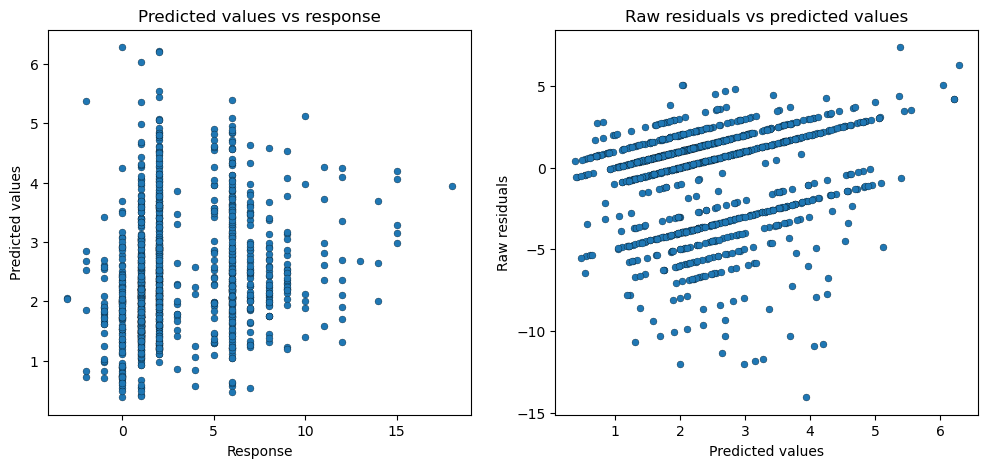

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot of predicted values vs actual values
ax1.scatter(y_test_def, ols_bs_def_test_predict, edgecolor='k', linewidths=0.2)
ax1.set_xlabel("Response")
ax1.set_ylabel("Predicted values")
ax1.set_title("Predicted values vs response")

# Plot of residuals vs fitted values
ax2.scatter(ols_bs_def_test_predict, ols_bs_def_test_resid, edgecolor='k', linewidths=0.2)
ax2.set_xlabel("Predicted values")
ax2.set_ylabel("Raw residuals")
ax2.set_title("Raw residuals vs predicted values")

plt.show()

In [64]:
# Compute OOS MAE and MSE
mae_bs = np.mean(abs(ols_bs_def_test_resid))
mse_bs = np.mean(ols_bs_def_test_resid**2)
print("MAE: {:.3f}\nMSE: {:.3f}".format(mae_bs, mse_bs))

MAE: 2.283
MSE: 9.490


## 4.2 Lasso Regression

We now move on to fitting penalised regressions in order to select important variables. We begin by performing a cross-validation to determine the optimal order of magnitude for the penalisation parameter. For both the lasso and ridge regressions we continue to fit the linear model to the response after having applied the Box-Cox transform as above.

In [65]:
# Run a lasso regression implementing 10-fold cross-validation for the selection of the tuning parameter
validation_idxs = split(X_train_def_boxcox.sample(frac=1).index, 10)
lasso_def_alpha_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
lasso_def_cv_error_dict = {'mae': [], 'mse': []}
for a in lasso_def_alpha_list:
    mae = []
    mse = []
    
    for i, idx in enumerate(validation_idxs):
        X_val_def_cv = X_train_def_boxcox.loc[idx]
        y_val_def_cv = y_train_def[idx]
        X_train_def_cv = X_train_def_boxcox.drop(idx, axis=0)
        y_train_def_cv = y_train_def_boxcox.drop(idx)
        
        lasso_def_model = sm.OLS(y_train_def_cv, X_train_def_cv)
        lasso_def_res = lasso_def_model.fit_regularized(alpha=a, L1_wt=1)
        
        lasso_def_cv_predict_boxcox = lasso_def_res.predict(X_val_def_cv)
        lasso_def_cv_predict = inverse_boxcox(lasso_def_cv_predict_boxcox, lmbda=lambda_def) - 1
        
        mae.append(np.mean(abs(lasso_def_cv_predict - y_val_def_cv)))
        mse.append(np.mean((lasso_def_cv_predict - y_val_def_cv)**2))
        
    lasso_def_cv_error_dict['mae'].append(np.mean(mae))
    lasso_def_cv_error_dict['mse'].append(np.mean(mse))

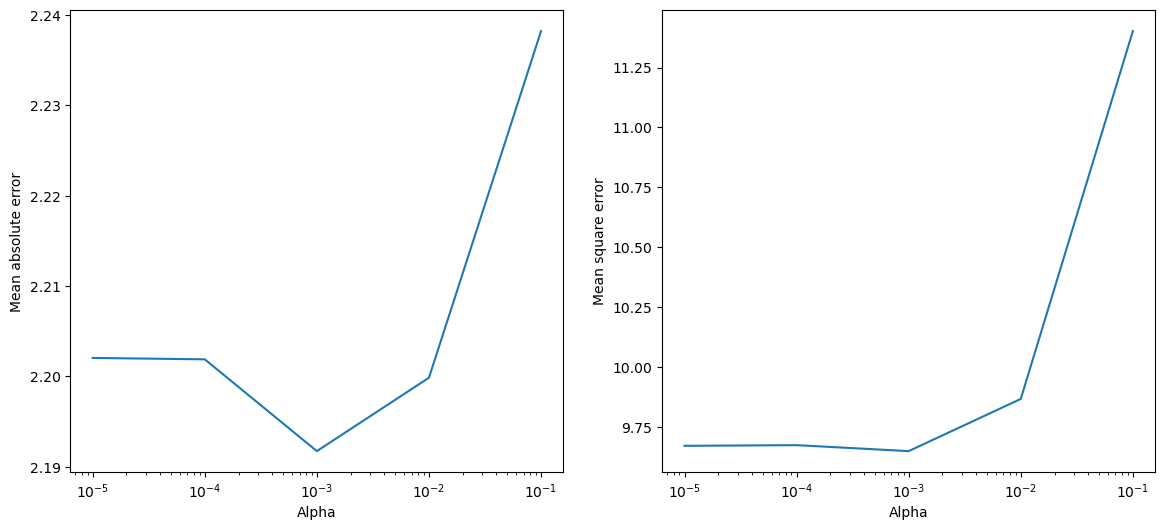

In [66]:
# Plot the MAE and MSE for different values of the tuning parameters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(lasso_def_alpha_list, lasso_def_cv_error_dict['mae'])
ax1.set_xscale("log")
ax1.set_xlabel("Alpha")
ax1.set_ylabel("Mean absolute error")

ax2.plot(lasso_def_alpha_list, lasso_def_cv_error_dict['mse'])
ax2.set_xscale("log")
ax2.set_xlabel("Alpha")
ax2.set_ylabel("Mean square error")

plt.show()

The plots above indicate that the best two options for the penalisation parameter, `alpha`, would be 0.1, which minimizes the mean absolute error, or 0.01, which minimizes the mean square error. Note that, here, the larger the size of the parameter the stricter the penalisation of the regression coefficients. I have chosen to use `alpha` = 0.01 as the minimizer of the mean square error on the validation sets.

In [161]:
# Fit the final lasso model
lasso_def_alpha = 1e-3

lasso_def_model = sm.OLS(y_train_def_boxcox, X_train_def_boxcox)
lasso_def_res = lasso_def_model.fit_regularized(alpha=lasso_def_alpha, L1_wt=1)

In [162]:
# Predict the response on the test set
lasso_def_test_predict_boxcox = lasso_def_res.predict(X_test_def2)
lasso_def_test_predict = inverse_boxcox(lasso_def_test_predict_boxcox, lmbda=lambda_def)
lasso_def_test_resid = lasso_def_test_predict - y_test_def

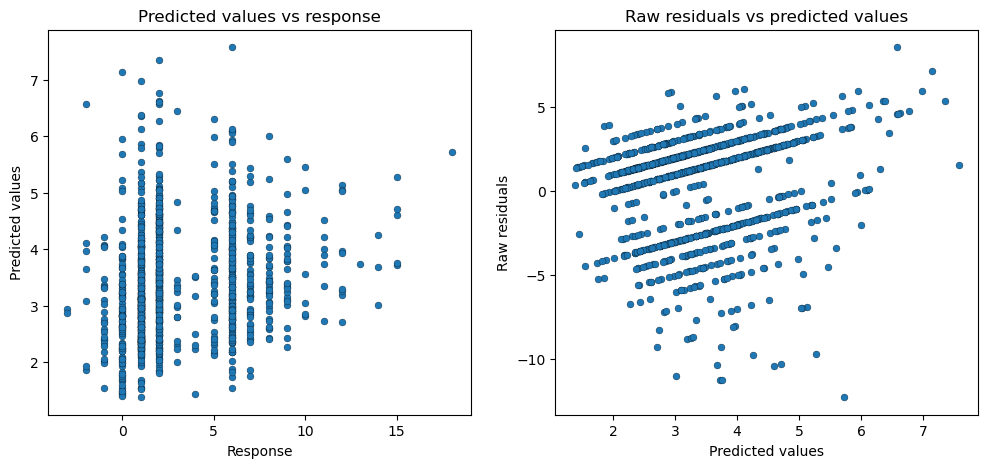

In [163]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot of predicted values vs actual values
ax1.scatter(y_test_def, lasso_def_test_predict, edgecolor='k', linewidths=0.2)
ax1.set_xlabel("Response")
ax1.set_ylabel("Predicted values")
ax1.set_title("Predicted values vs response")

# Plot of residuals vs fitted values
ax2.scatter(lasso_def_test_predict, lasso_def_test_resid, edgecolor='k', linewidths=0.2)
ax2.set_xlabel("Predicted values")
ax2.set_ylabel("Raw residuals")
ax2.set_title("Raw residuals vs predicted values")

plt.show()

In [164]:
# Compute OOS MAE and MSE
lasso_def_mae = np.mean(abs(lasso_def_test_resid))
lasso_def_mse = np.mean(lasso_def_test_resid**2)
print("MAE: {:.3f}\nMSE: {:.3f}".format(lasso_def_mae, lasso_def_mse))

MAE: 2.559
MSE: 9.229


## 4.3 Ridge Regression

In [71]:
# Run a ridge regression implementing 10-fold cross-validation for the selection of the tuning parameter
ridge_def_alpha_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
ridge_def_cv_error_dict = {'mae': [], 'mse': []}
for a in ridge_def_alpha_list:
    mae = []
    mse = []
    
    for i, idx in enumerate(validation_idxs):
        X_val_def_cv = X_train_def_boxcox.loc[idx]
        y_val_def_cv = y_train_def[idx]
        X_train_def_cv = X_train_def_boxcox.drop(idx, axis=0)
        y_train_def_cv = y_train_def_boxcox.drop(idx)
        
        ridge_def_model = sm.OLS(y_train_def_cv, X_train_def_cv)
        ridge_def_res = ridge_def_model.fit_regularized(alpha=a, L1_wt=0)
        
        ridge_def_cv_predict_boxcox = ridge_def_res.predict(X_val_def_cv)
        ridge_def_cv_predict = inverse_boxcox(ridge_def_cv_predict_boxcox, lmbda=lambda_def) - 1
        
        mae.append(np.mean(abs(ridge_def_cv_predict - y_val_def_cv)))
        mse.append(np.mean((ridge_def_cv_predict - y_val_def_cv)**2))
        
    ridge_def_cv_error_dict['mae'].append(np.mean(mae))
    ridge_def_cv_error_dict['mse'].append(np.mean(mse))

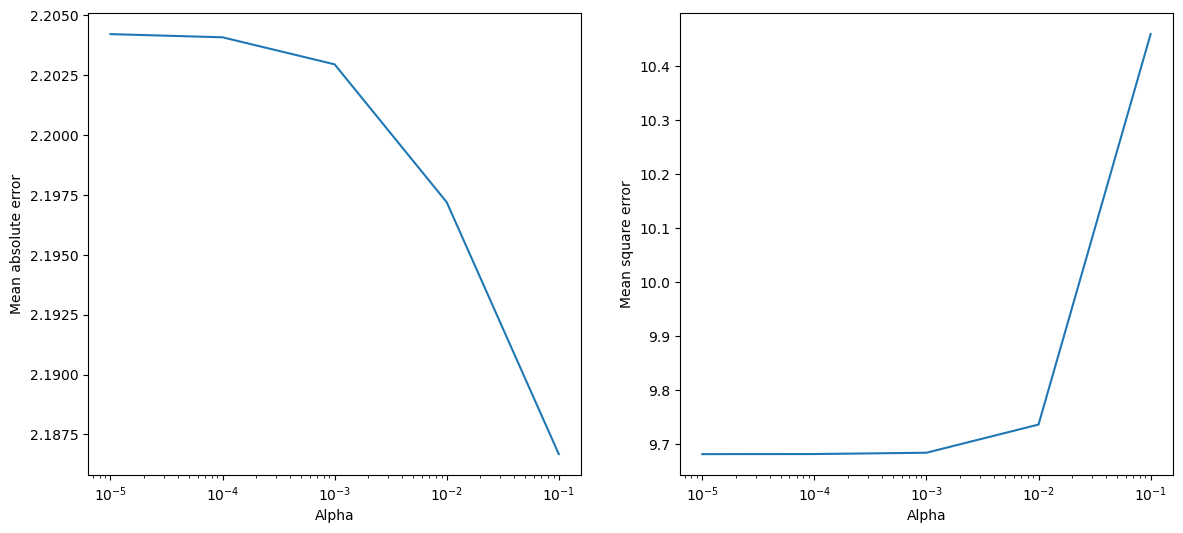

In [72]:
# Plot the MAE and MSE on the validation sets for different values of the tuning parameters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(ridge_def_alpha_list, ridge_def_cv_error_dict['mae'])
ax1.set_xscale("log")
ax1.set_xlabel("Alpha")
ax1.set_ylabel("Mean absolute error")

ax2.plot(ridge_def_alpha_list, ridge_def_cv_error_dict['mse'])
ax2.set_xscale("log")
ax2.set_xlabel("Alpha")
ax2.set_ylabel("Mean square error")

plt.show()

In [165]:
# Fit the final ridge model
ridge_def_alpha = 1e-2

ridge_def_model = sm.OLS(y_train_def_boxcox, X_train_def_boxcox)
ridge_def_res = ridge_def_model.fit_regularized(alpha=ridge_def_alpha, L1_wt=0)

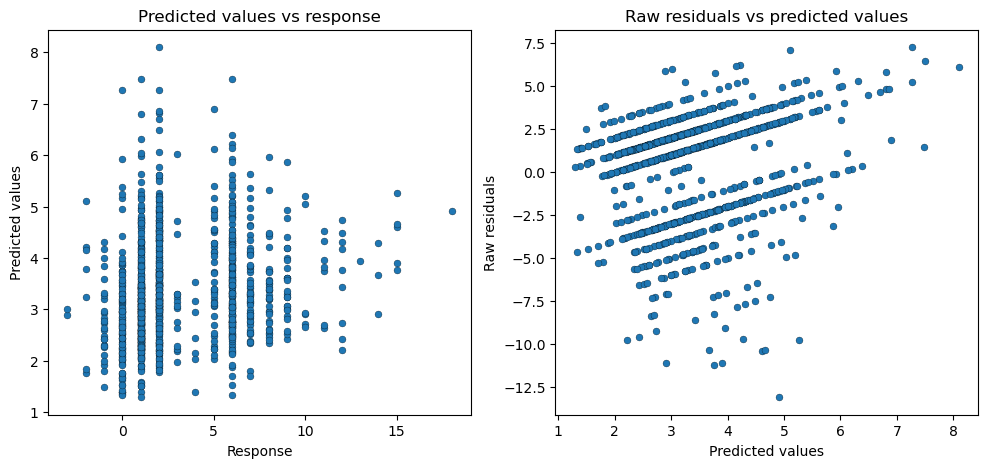

In [166]:
# Predict the response on the test set
ridge_def_test_predict_boxcox = ridge_def_res.predict(X_test_def2)
ridge_def_test_predict = inverse_boxcox(ridge_def_test_predict_boxcox, lmbda=lambda_def)
ridge_def_test_resid = ridge_def_test_predict - y_test_def

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot of predicted values vs actual values
ax1.scatter(y_test_def, ridge_def_test_predict, edgecolor='k', linewidths=0.2)
ax1.set_xlabel("Response")
ax1.set_ylabel("Predicted values")
ax1.set_title("Predicted values vs response")

# Plot of residuals vs fitted values
ax2.scatter(ridge_def_test_predict, ridge_def_test_resid, edgecolor='k', linewidths=0.2)
ax2.set_xlabel("Predicted values")
ax2.set_ylabel("Raw residuals")
ax2.set_title("Raw residuals vs predicted values")

plt.show()

In [167]:
# Compute OOS MAE and MSE
ridge_def_mae = np.mean(abs(ridge_def_test_resid))
ridge_def_mse = np.mean(ridge_def_test_resid**2)
print("MAE: {:.3f}\nMSE: {:.3f}".format(ridge_def_mae, ridge_def_mse))

MAE: 2.551
MSE: 9.335


## 4.4 Random Forest Regression

In [172]:
# Conduct 10-fold cross-validation on the parameter grid to select hyperparameters for the random forest
rf_def_param_grid = {'max_depth': [1, 2, 3, 5, 7, 10, 15, 20],
                    'n_estimators': [50, 100, 200, 500, 1000],
                    'max_features': [None, 'log2', 'sqrt']}
scoring_metrics = ['neg_mean_absolute_error', 'neg_mean_squared_error']
rf_def_cv_results = GridSearchCV(RandomForestRegressor(), 
                                rf_def_param_grid, 
                                scoring=scoring_metrics,
                                cv=10,
                                refit=False)
rf_def_cv_results.fit(X_train_def1, y_train_def)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 2, 3, 5, 7, 10, 15, 20],
                         'max_features': [None, 'log2', 'sqrt'],
                         'n_estimators': [50, 100, 200, 500, 1000]},
             refit=False,
             scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'])

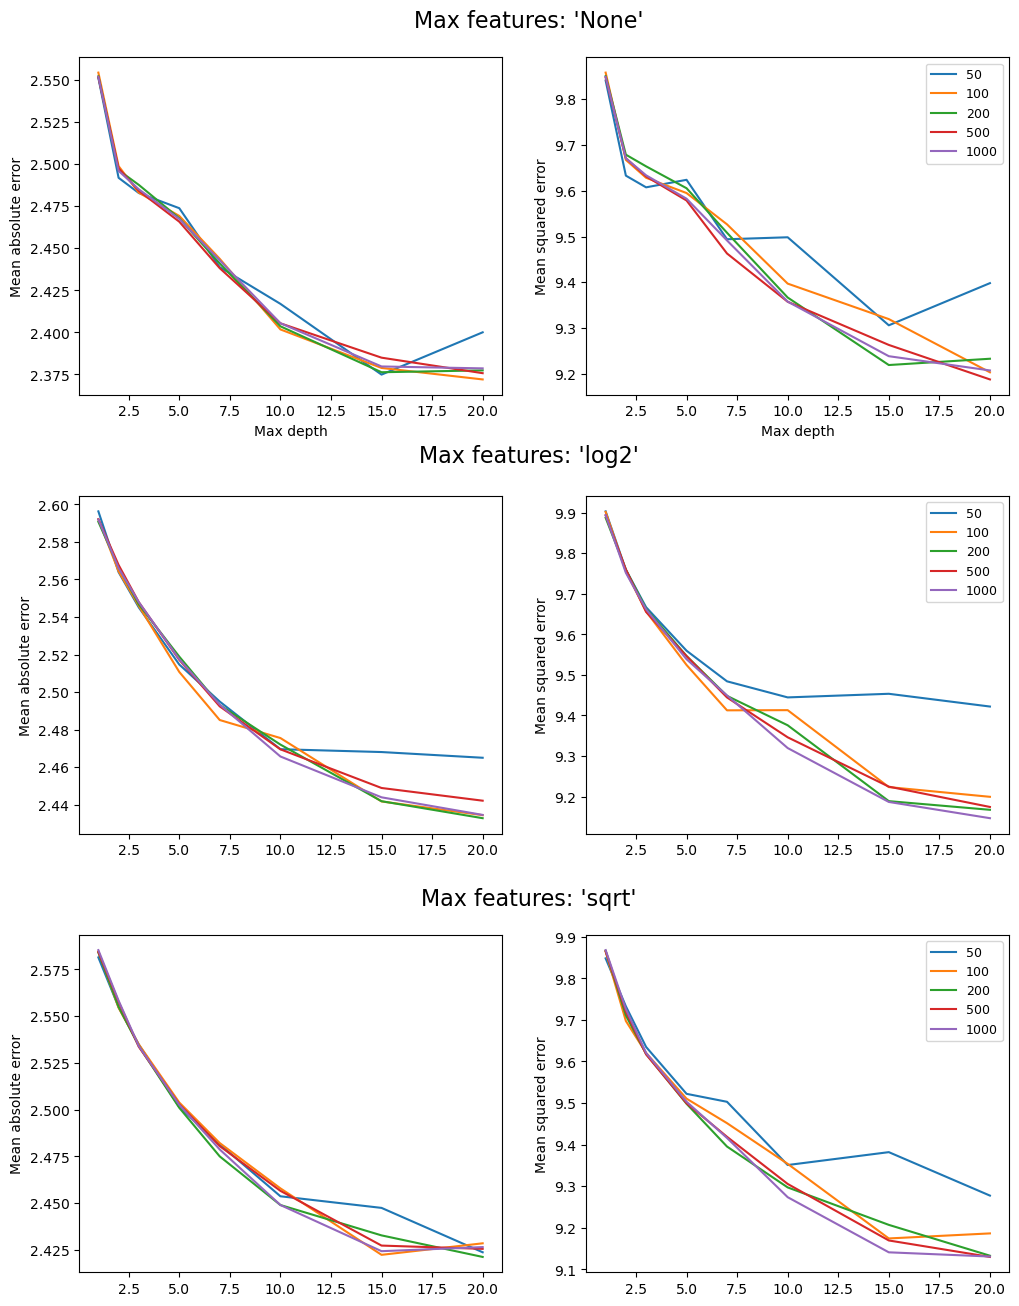

In [176]:
cv_results = rf_def_cv_results.cv_results_

fig, axs = plt.subplots(3, 2, figsize=(12, 15))
fig.subplots_adjust(hspace=0.3, top=0.92)

for i, max_features in enumerate(rf_def_param_grid['max_features']):
    for n in rf_def_param_grid['n_estimators']:
        data_idx_bool = ((cv_results['param_max_features'] == max_features) & (cv_results['param_n_estimators'] == n))
        depth_data = cv_results['param_max_depth'][data_idx_bool]
        
        mae_data = -1*cv_results['mean_test_neg_mean_absolute_error'][data_idx_bool]
        # mae_error_data = cv_results['std_test_neg_mean_absolute_error'][data_idx_bool]
        
        mse_data = -1*cv_results['mean_test_neg_mean_squared_error'][data_idx_bool]
        # mse_error_data = cv_results['std_test_neg_mean_squared_error'][data_idx_bool]
        
        axs[i, 0].plot(depth_data, mae_data, label=f"{n}")
        axs[i, 1].plot(depth_data, mse_data, label=f"{n}")
        
        axs[i, 0].set_ylabel("Mean absolute error")
        axs[i, 1].set_ylabel("Mean squared error")
    
axs[0, 0].set_xlabel("Max depth")
axs[0, 1].set_xlabel("Max depth")

# Add title and subtitles to figure
fig.text(0.5, 0.94, 
         f"Max features: '{rf_def_param_grid['max_features'][0]}'", 
         fontsize=16, 
         horizontalalignment='center')
fig.text(0.5, 0.65, 
         f"Max features: '{rf_def_param_grid['max_features'][1]}'", 
         fontsize=16, 
         horizontalalignment='center')
fig.text(0.5, 0.355, 
         f"Max features: '{rf_def_param_grid['max_features'][2]}'", 
         fontsize=16, 
         horizontalalignment='center')

# Add legends to axes
axs[0, 1].legend(fontsize=9)
axs[1, 1].legend(fontsize=9)
axs[2, 1].legend(fontsize=9)

plt.show()

In [79]:
# # Fit the random forest regression model with hyperparameters as determined above
# max_depth_final = 4
# n_estimators_final = 1000
# rf_def_model1 = RandomForestRegressor(max_depth=max_depth_final, random_state=0, oob_score=True, n_estimators=n_estimators_final)
# rf_def_model1.fit(X_train_def1, y_train_def)

# rf1_def_predict_train = rf_def_model1.predict(X_train_def1)
# rf1_def_predict_test = rf_def_model1.predict(X_test_def1)

# rf1_def_resid_train = rf1_def_predict_train - y_train_def
# rf1_def_resid_test = rf1_def_predict_test - y_test_def

# rf1_def_train_mae = np.mean(abs(resid_train))
# rf1_def_test_mae = np.mean(abs(resid_test))
# rf1_def_train_mse = np.mean(resid_train**2)
# rf1_def_test_mse = np.mean(resid_test**2)

# print("MAE on test set = {}\nMSE on test set = {}".format(rf1_def_test_mae, rf1_def_test_mse))

In [80]:
# # Examine feature importance
# feature_importances = (pd.Series(rf_def_model1.feature_importances_, index=X_train_def1.columns)
#                        .sort_values()
#                        .to_frame(name='importance'))
# feature_importances['rank'] = feature_importances.importance.rank(ascending=False)
# fig, ax = plt.subplots(figsize=(8, 52))
# ax.margins(y = 0.0025)
# ax.barh(feature_importances.index, feature_importances.importance)
# plt.show()

In [81]:
# importance_threshold = 0.005
# rf_vars_initial = feature_importances.loc[feature_importances.importance >= importance_threshold].index.tolist()
# n_vars = len(rf_vars_initial)
# print("No. of variables = {}".format(len(feature_importances)))
# print("No. of variables above importance threshold = {}".format(len(rf_vars_initial)))

In [82]:
# # We will only perform the variable selection CV using variables that are above the importance threshold in the initial model
# # since running this for all variables would be time-consuming although theoretically preferred.

# # Set up the variable selection cross-validation
# validation_sets = split(X_train_def1.index, 10)
# max_depth = 4
# n_estimators_list = [1000]
# cv_info = {n: {} for n in n_estimators_list}

# for n_estimators in n_estimators_list:
#     Z_train = X_train_def1[rf_vars_initial]
#     Z_test = X_test_def1[rf_vars_initial]
#     rf_vars_current = rf_vars_initial.copy()
#     cv_info[n_estimators] = {x: {} for x in range(1, len(rf_vars_initial)+1)}

#     while len(rf_vars_current) > 0: 
#         print(len(rf_vars_current))
#         cv_info[n_estimators][len(rf_vars_current)]['vars'] = rf_vars_current.copy()

#         Z_train = Z_train[rf_vars_current]
#         rf_regr_vs = RandomForestRegressor(max_depth=max_depth,
#                                             random_state=0,
#                                             oob_score=True,
#                                             n_estimators=n_estimators)
#         rf_regr_vs.fit(Z_train, y_train_def)

#         # Get MAE and MSE estimates using cross-validation
#         mae = []
#         mse = []
#         for validation_idxs in validation_sets:
#             Z_train1 = Z_train.drop(validation_idxs, axis=0)
#             y_train_def1 = y_train_def.drop(validation_idxs)
#             Z_val = Z_train.loc[validation_idxs]
#             y_val_def = y_train_def.loc[validation_idxs]

#             rf_regr = RandomForestRegressor(max_depth=max_depth,
#                                             random_state=0,
#                                             oob_score=True,
#                                             n_estimators=n_estimators)
#             rf_regr.fit(Z_train1, y_train_def1)

#             predict_val = rf_regr.predict(Z_val)
#             resid_val = predict_val - y_val_def
#             mae.append(np.mean(abs(resid_val)))
#             mse.append(np.mean(resid_val**2))

#         cv_info[n_estimators][len(rf_vars_current)]['mae'] = np.mean(mae)
#         cv_info[n_estimators][len(rf_vars_current)]['mse'] = np.mean(mse)

#         var_importances = pd.Series(rf_regr_vs.feature_importances_, index=rf_vars_current).sort_values()
#         drop_var = var_importances.index[0]
#         rf_vars_current.remove(var_importances.index[0])

    

In [83]:
# idx = np.linspace(1, n_vars, n_vars)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# for n_estimators in n_estimators_list:
#     mae_varselect_cv = [cv_info[n_estimators][x]['mae'] for x in cv_info[n_estimators]]
#     mse_varselect_cv = [cv_info[n_estimators][x]['mse'] for x in cv_info[n_estimators]]
    
#     ax1.plot(idx, mae_varselect_cv, label="{}".format(n_estimators))
#     ax2.plot(idx, mse_varselect_cv, label="{}".format(n_estimators))
    
# ax1.set_xlabel("No. of variables")
# ax1.set_ylabel("Validation MAE")
# ax1.legend()
# ax2.set_xlabel("No. of variables")
# ax2.set_ylabel("Validation MSE")
# ax2.legend()

# plt.show()

In [84]:
# # Fit the model after selecting variables
# n_estimators_final = 1000
# n_vars_final = 22
# def_rf_vars_final = cv_info[n_estimators_final][n_vars_final]['vars']
# X_train_def_rf = X_train_def1[def_rf_vars_final]
# X_test_def_rf = X_test_def1[def_rf_vars_final]

# rf_def_model2 = RandomForestRegressor(max_depth=4, oob_score=True, n_estimators=n_estimators_final)
# rf_def_model2.fit(X_train_def_rf, y_train_def)

# rf2_def_test_predict = rf_def_model2.predict(X_test_def_rf)
# rf2_def_test_resid = rf2_def_test_predict - y_test_def
# rf2_def_test_mae = np.mean(abs(rf2_def_test_resid))
# rf2_def_test_mse = np.mean(rf2_def_test_resid**2)
# print("MAE on test set = {:.3f}\nMSE on test set = {:.3f}".format(rf2_def_test_mae, rf2_def_test_mse))

# 5 Midfielder modelling

In [85]:
# Drop highly correlated columns
drop_cols = (["opp_npxGA_{}".format(x) for x in range(1, 5)] +
             ["opp_npxG_{}".format(x) for x in range(1, 5)] + 
             ["team_npxG_{}".format(x) for x in range(1, 5)] + 
             ["team_npxGA_{}".format(x) for x in range(1, 5)] +
             ["selected_{}".format(x) for x in range(1, 5)] + 
             ["value_{}".format(x) for x in range(1, 5)] + 
             ["creativity_{}".format(x) for x in range(1, 5)] + 
             ["influence_{}".format(x) for x in range(1, 5)] + 
             ["npxG_{}".format(x) for x in range(1, 5)] + 
             ["npg_{}".format(x) for x in range(1, 5)] + 
             ["starts_{}".format(x) for x in range(1, 5)] + 
             ["bps_{}".format(x) for x in range(1, 5)]
            )

X_train_mid2 = X_train_mid1.drop(drop_cols, axis=1)
X_test_mid2 = X_test_mid1.drop(drop_cols, axis=1)

## 5.1 Ordinary Least Squares

In [86]:
# Fit an initial linear model to the training data
ols_model_mid = sm.OLS(y_train_mid, X_train_mid2)
ols_res_mid = ols_model_mid.fit()

ols_mid_resid = ols_res_mid.resid_pearson
ols_mid_fv = ols_res_mid.fittedvalues

The QQ plot of standardised residuals vs the theoretical quantiles appears to show significant skew in the distribution of residuals. Much like the plot for the goalkeepers, the plot of standardised residuals appears to indicate heteroskedasticity in the standardised residuals, with smaller variance in residuals for lower fitted values.

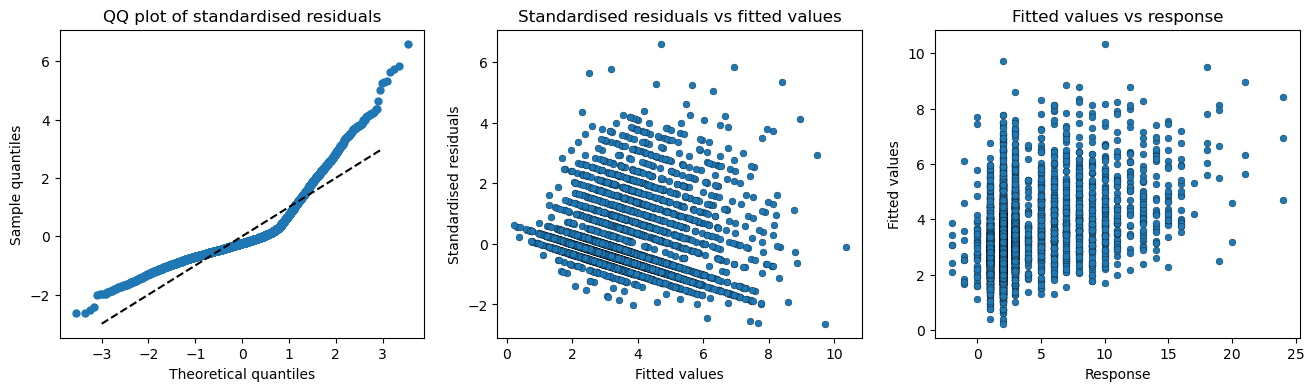

In [87]:
gof_plots(y_train_mid, ols_mid_resid, ols_mid_fv)

I now want to apply the model to the test data in order to assess its performance. As a baseline model I will use the average value from the training data and assign this as the predicted value for all test set data. Then, we can compare the performance of future models against this uninformed model.

In [88]:
# Compute the test MAE and MSE under the use of the training mean as a constant model
mid_baseline_mae = np.mean(abs(y_train_mid.mean() - y_test_mid))
mid_baseline_mse = np.mean((y_train_mid.mean() - y_test_mid)**2)
print("MAE: {:.3f}\nMSE: {:.3f}".format(mid_baseline_mae, mid_baseline_mse))

MAE: 2.192
MSE: 9.107


In [89]:
# Get predicted values for the test data
X_test_mid2 = X_test_mid1[X_train_mid2.columns]
ols_mid_test_predict = ols_res_mid.predict(X_test_mid2)
ols_mid_test_resid = ols_mid_test_predict - y_test_mid

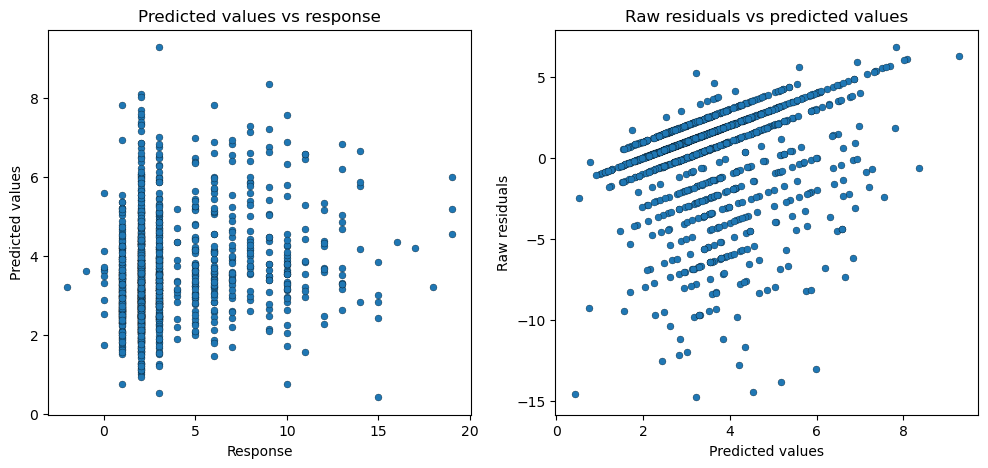

In [90]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot of predicted values vs actual values
ax1.scatter(y_test_mid, ols_mid_test_predict, edgecolor='k', linewidths=0.2)
ax1.set_xlabel("Response")
ax1.set_ylabel("Predicted values")
ax1.set_title("Predicted values vs response")

# Plot of residuals vs fitted values
ax2.scatter(ols_mid_test_predict, ols_mid_test_resid, edgecolor='k', linewidths=0.2)
ax2.set_xlabel("Predicted values")
ax2.set_ylabel("Raw residuals")
ax2.set_title("Raw residuals vs predicted values")

plt.show()

In [91]:
# Compute test MAE and MSE
ols_mid_test_mae = np.mean(abs(ols_mid_test_resid))
ols_mid_test_mse = np.mean(ols_mid_test_resid**2)
print("MAE: {:.3f}\nMSE: {:.3f}".format(ols_mid_test_mae, ols_mid_test_mse))

MAE: 2.147
MSE: 9.104


In [92]:
shift = 1
y_train_mid_boxcox = y_train_mid.drop(y_train_mid.loc[y_train_mid < 0].index) + shift
y_train_mid_boxcox_index = y_train_mid_boxcox.index
X_train_mid_boxcox = X_train_mid2.drop(y_train_mid.loc[y_train_mid < 0].index)

y_train_mid_boxcox, lambda_mid = stats.boxcox(y_train_mid_boxcox)

y_train_mid_boxcox = pd.Series(y_train_mid_boxcox, y_train_mid_boxcox_index)

In [93]:
# Perform stepwise backward elimination, removing variables whose coefficient estimates do not have p-values falling below
# the specified threshold
priority_list_mid = priority_list.copy()
dropped_cols = []
X_train_mid_temp = X_train_mid_boxcox.copy()
selection_complete = False
p_value_threshold = 0.1

while not selection_complete:
    model_temp = sm.OLS(y_train_mid_boxcox, X_train_mid_temp)
    res_temp = model_temp.fit()
    drop_candidates = res_temp.pvalues.loc[res_temp.pvalues > p_value_threshold]
    if len(drop_candidates) == 0:
        selection_complete = True
        continue
    
    drop_col = priority_list_mid.pop([col in drop_candidates for col in priority_list_mid].index(True))
    dropped_cols.append(drop_col)
    X_train_mid_temp.drop(drop_col, axis=1, inplace=True)

In [94]:
# Examine model chosen by backward elimination
X_train_mid_bs = sm.add_constant(X_train_mid_temp)
ols_bs_model_mid = sm.OLS(y_train_mid_boxcox, X_train_mid_bs)
ols_bs_res_mid = ols_bs_model_mid.fit()

print(ols_bs_res_mid.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     19.27
Date:                Sat, 13 Apr 2024   Prob (F-statistic):          2.42e-105
Time:                        09:06:48   Log-Likelihood:                 331.52
No. Observations:                5000   AIC:                            -595.0
Df Residuals:                    4966   BIC:                            -373.5
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

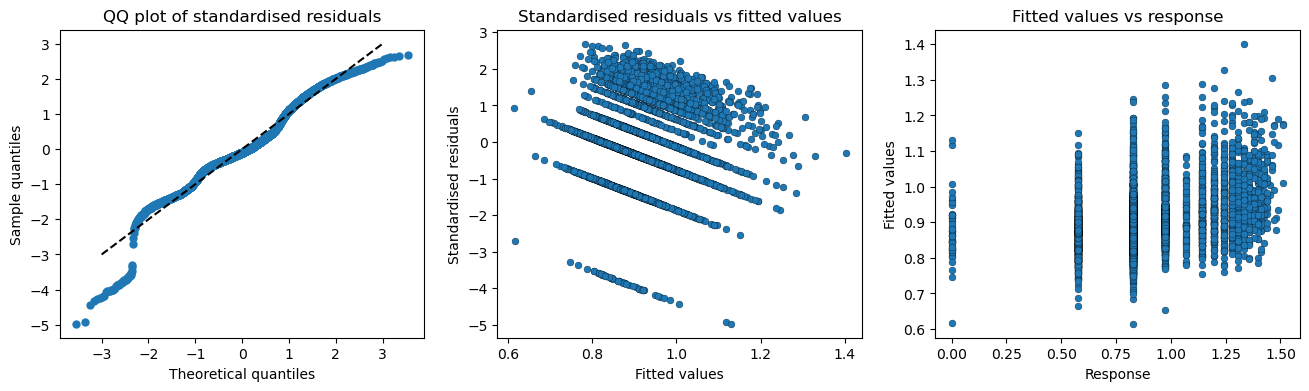

In [95]:
ols_bs_mid_resid = ols_bs_res_mid.resid_pearson
ols_bs_mid_fv = ols_bs_res_mid.fittedvalues

gof_plots(y_train_mid_boxcox, ols_bs_mid_resid, ols_bs_mid_fv)

The above diagnostic plots show that there has been an improvement in the specification of the model as a result of the transformation of the response variable and the application of the backward elimination variable selection process. The QQ plot indicates that the standardised residuals more closely fit the standard normal distribution; the plot of standardised residuals vs fitted values shows a decrease in clear heteroskedasticity in the residuals; and, although the fitted values vs response plot shows an increase in variablility, this is likely due to overfitting in the previous model.

In [96]:
# Apply the backward selection model to the test data
X_test_mid_bs = X_test_mid1[X_train_mid_bs.columns]

# Apply inverse Box-Cox transformation to the predicted values
ols_bs_mid_test_predict_boxcox = ols_bs_res_mid.predict(X_test_mid_bs)
ols_bs_mid_test_predict = inverse_boxcox(ols_bs_mid_test_predict_boxcox, lmbda=lambda_mid) - 1

ols_bs_mid_test_resid = ols_bs_mid_test_predict - y_test_mid

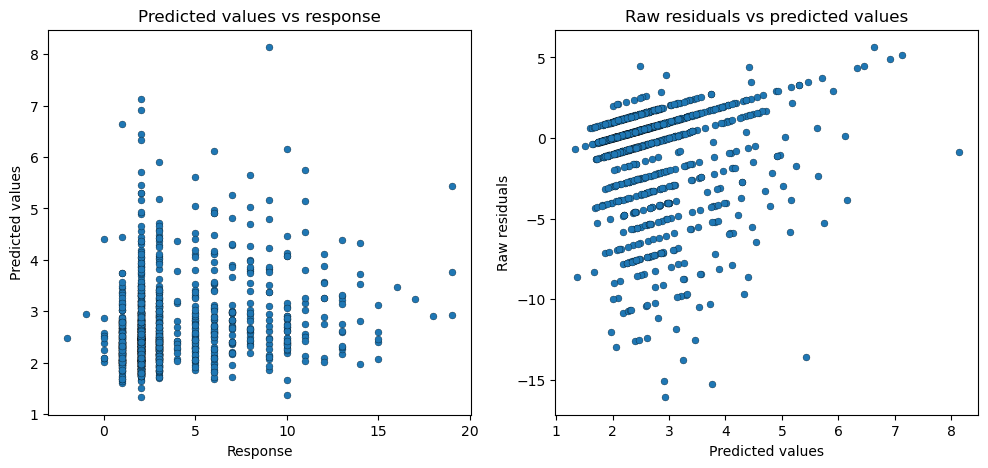

In [97]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot of predicted values vs actual values
ax1.scatter(y_test_mid, ols_bs_mid_test_predict, edgecolor='k', linewidths=0.2)
ax1.set_xlabel("Response")
ax1.set_ylabel("Predicted values")
ax1.set_title("Predicted values vs response")

# Plot of residuals vs fitted values
ax2.scatter(ols_bs_mid_test_predict, ols_bs_mid_test_resid, edgecolor='k', linewidths=0.2)
ax2.set_xlabel("Predicted values")
ax2.set_ylabel("Raw residuals")
ax2.set_title("Raw residuals vs predicted values")

plt.show()

In [98]:
# Compute OOS MAE and MSE
mae_bs = np.mean(abs(ols_bs_mid_test_resid))
mse_bs = np.mean(ols_bs_mid_test_resid**2)
print("MAE: {:.3f}\nMSE: {:.3f}".format(mae_bs, mse_bs))

MAE: 1.836
MSE: 9.206


## 5.2 Lasso Regression

We now move on to fitting penalised regressions in order to select important variables. We begin by performing a cross-validation to determine the optimal order of magnitude for the penalisation parameter. For both the lasso and ridge regressions we continue to fit the linear model to the response after having applied the Box-Cox transform as above.

In [99]:
# Run a lasso regression implementing 10-fold cross-validation for the selection of the tuning parameter
validation_idxs = split(X_train_mid_boxcox.sample(frac=1).index, 10)
lasso_mid_alpha_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
lasso_mid_cv_error_dict = {'mae': [], 'mse': []}
for a in lasso_mid_alpha_list:
    mae = []
    mse = []
    
    for i, idx in enumerate(validation_idxs):
        X_val_mid_cv = X_train_mid_boxcox.loc[idx]
        y_val_mid_cv = y_train_mid[idx]
        X_train_mid_cv = X_train_mid_boxcox.drop(idx, axis=0)
        y_train_mid_cv = y_train_mid_boxcox.drop(idx)
        
        lasso_mid_model = sm.OLS(y_train_mid_cv, X_train_mid_cv)
        lasso_mid_res = lasso_mid_model.fit_regularized(alpha=a, L1_wt=1)
        
        lasso_mid_cv_predict_boxcox = lasso_mid_res.predict(X_val_mid_cv)
        lasso_mid_cv_predict = inverse_boxcox(lasso_mid_cv_predict_boxcox, lmbda=lambda_mid) - 1
        
        mae.append(np.mean(abs(lasso_mid_cv_predict - y_val_mid_cv)))
        mse.append(np.mean((lasso_mid_cv_predict - y_val_mid_cv)**2))
        
    lasso_mid_cv_error_dict['mae'].append(np.mean(mae))
    lasso_mid_cv_error_dict['mse'].append(np.mean(mse))

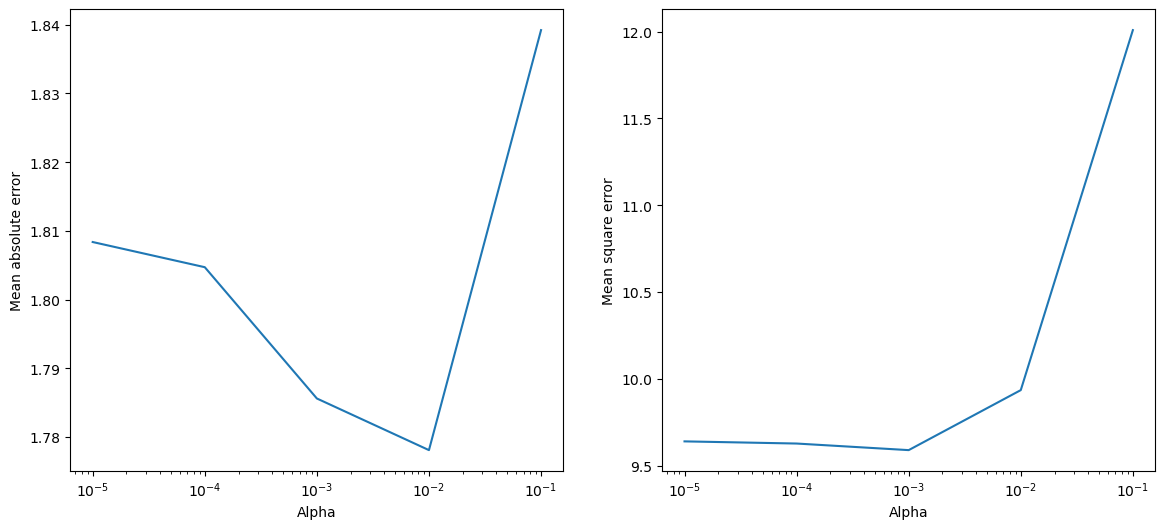

In [100]:
# Plot the MAE and MSE for different values of the tuning parameters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(lasso_mid_alpha_list, lasso_mid_cv_error_dict['mae'])
ax1.set_xscale("log")
ax1.set_xlabel("Alpha")
ax1.set_ylabel("Mean absolute error")

ax2.plot(lasso_mid_alpha_list, lasso_mid_cv_error_dict['mse'])
ax2.set_xscale("log")
ax2.set_xlabel("Alpha")
ax2.set_ylabel("Mean square error")

plt.show()

In [168]:
# Fit the final lasso model
lasso_mid_alpha = 1e-3

lasso_mid_model = sm.OLS(y_train_mid_boxcox, X_train_mid_boxcox)
lasso_mid_res = lasso_mid_model.fit_regularized(alpha=lasso_mid_alpha, L1_wt=1)

In [169]:
# Predict the response on the test set
lasso_mid_test_predict_boxcox = lasso_mid_res.predict(X_test_mid2)
lasso_mid_test_predict = inverse_boxcox(lasso_mid_test_predict_boxcox, lmbda=lambda_mid)
lasso_mid_test_resid = lasso_mid_test_predict - y_test_mid

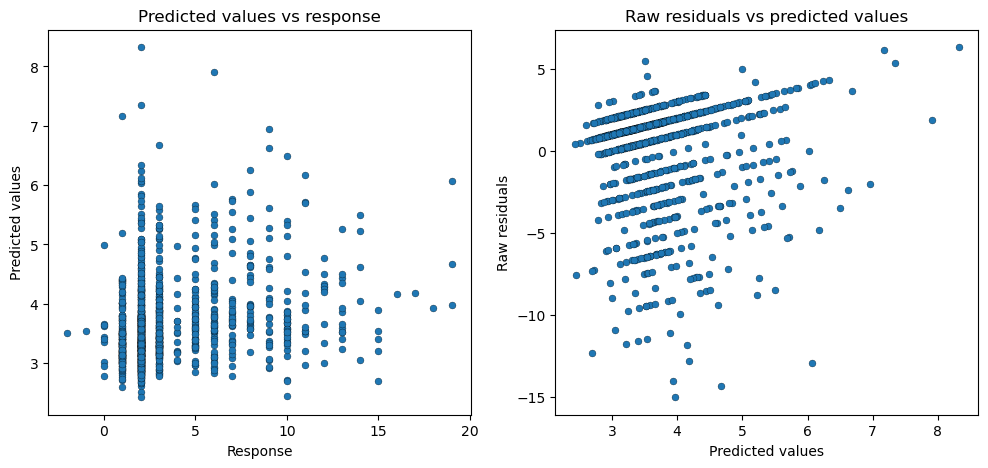

In [170]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot of predicted values vs actual values
ax1.scatter(y_test_mid, lasso_mid_test_predict, edgecolor='k', linewidths=0.2)
ax1.set_xlabel("Response")
ax1.set_ylabel("Predicted values")
ax1.set_title("Predicted values vs response")

# Plot of residuals vs fitted values
ax2.scatter(lasso_mid_test_predict, lasso_mid_test_resid, edgecolor='k', linewidths=0.2)
ax2.set_xlabel("Predicted values")
ax2.set_ylabel("Raw residuals")
ax2.set_title("Raw residuals vs predicted values")

plt.show()

In [171]:
# Compute OOS MAE and MSE
lasso_mid_mae = np.mean(abs(lasso_mid_test_resid))
lasso_mid_mse = np.mean(lasso_mid_test_resid**2)
print("MAE: {:.3f}\nMSE: {:.3f}".format(lasso_mid_mae, lasso_mid_mse))

MAE: 2.174
MSE: 8.603


## 5.3 Ridge Regression

In [105]:
# Run a ridge regression implementing 10-fold cross-validation for the selection of the tuning parameter
ridge_mid_alpha_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
ridge_mid_cv_error_dict = {'mae': [], 'mse': []}
for a in ridge_mid_alpha_list:
    mae = []
    mse = []
    
    for i, idx in enumerate(validation_idxs):
        X_val_mid_cv = X_train_mid_boxcox.loc[idx]
        y_val_mid_cv = y_train_mid[idx]
        X_train_mid_cv = X_train_mid_boxcox.drop(idx, axis=0)
        y_train_mid_cv = y_train_mid_boxcox.drop(idx)
        
        ridge_mid_model = sm.OLS(y_train_mid_cv, X_train_mid_cv)
        ridge_mid_res = ridge_mid_model.fit_regularized(alpha=a, L1_wt=0)
        
        ridge_mid_cv_predict_boxcox = ridge_mid_res.predict(X_val_mid_cv)
        ridge_mid_cv_predict = inverse_boxcox(ridge_mid_cv_predict_boxcox, lmbda=lambda_mid) - 1
        
        mae.append(np.mean(abs(ridge_mid_cv_predict - y_val_mid_cv)))
        mse.append(np.mean((ridge_mid_cv_predict - y_val_mid_cv)**2))
        
    ridge_mid_cv_error_dict['mae'].append(np.mean(mae))
    ridge_mid_cv_error_dict['mse'].append(np.mean(mse))

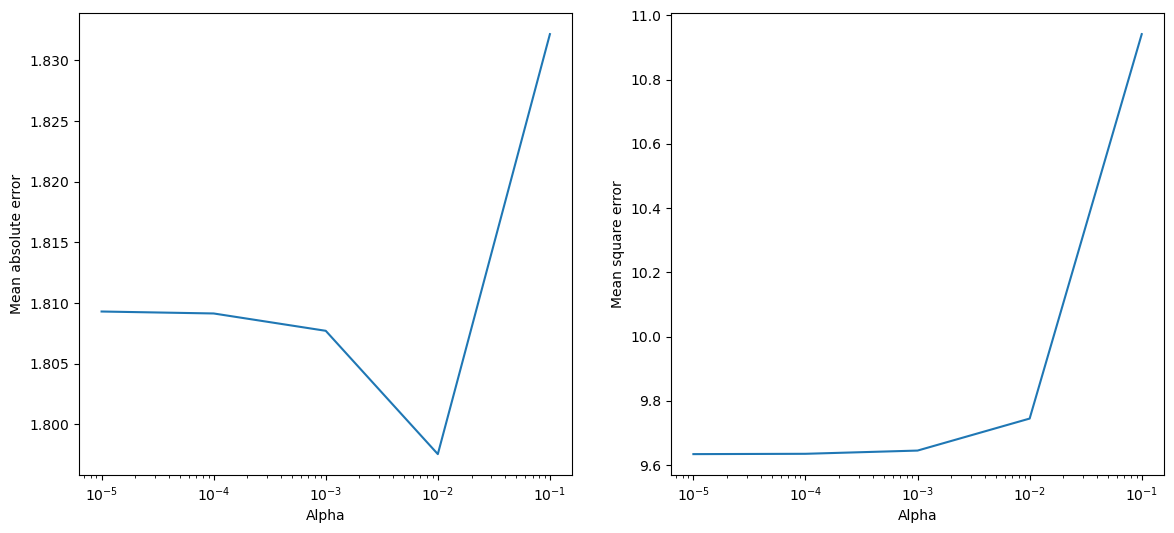

In [106]:
# Plot the MAE and MSE on the validation sets for different values of the tuning parameters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(ridge_mid_alpha_list, ridge_mid_cv_error_dict['mae'])
ax1.set_xscale("log")
ax1.set_xlabel("Alpha")
ax1.set_ylabel("Mean absolute error")

ax2.plot(ridge_mid_alpha_list, ridge_mid_cv_error_dict['mse'])
ax2.set_xscale("log")
ax2.set_xlabel("Alpha")
ax2.set_ylabel("Mean square error")

plt.show()

In [107]:
# Fit the final ridge model
ridge_mid_alpha = 1e-2

ridge_mid_model = sm.OLS(y_train_mid_boxcox, X_train_mid_boxcox)
ridge_mid_res = ridge_mid_model.fit_regularized(alpha=ridge_mid_alpha, L1_wt=0)

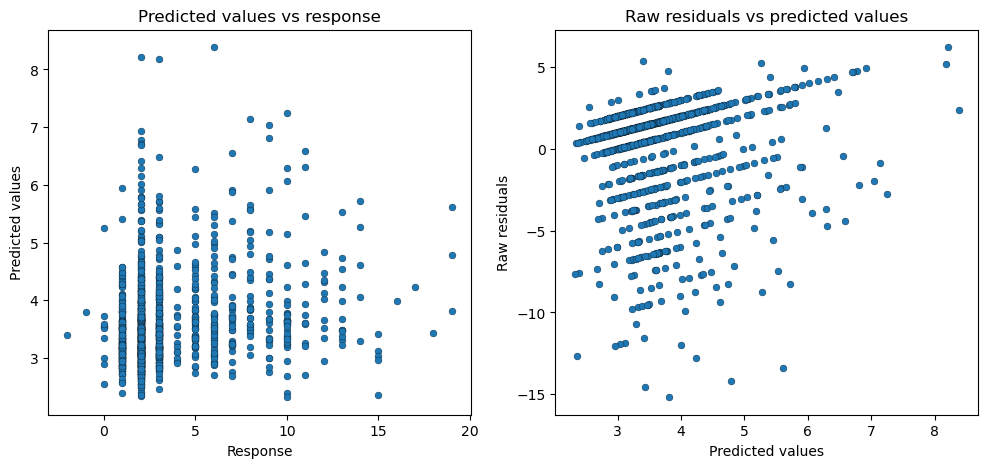

In [108]:
# Predict the response on the test set
ridge_mid_test_predict_boxcox = ridge_mid_res.predict(X_test_mid2)
ridge_mid_test_predict = inverse_boxcox(ridge_mid_test_predict_boxcox, lmbda=lambda_mid)
ridge_mid_test_resid = ridge_mid_test_predict - y_test_mid

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot of predicted values vs actual values
ax1.scatter(y_test_mid, ridge_mid_test_predict, edgecolor='k', linewidths=0.2)
ax1.set_xlabel("Response")
ax1.set_ylabel("Predicted values")
ax1.set_title("Predicted values vs response")

# Plot of residuals vs fitted values
ax2.scatter(ridge_mid_test_predict, ridge_mid_test_resid, edgecolor='k', linewidths=0.2)
ax2.set_xlabel("Predicted values")
ax2.set_ylabel("Raw residuals")
ax2.set_title("Raw residuals vs predicted values")

plt.show()

In [109]:
# Compute OOS MAE and MSE
ridge_mid_mae = np.mean(abs(ridge_mid_test_resid))
ridge_mid_mse = np.mean(ridge_mid_test_resid**2)
print("MAE: {:.3f}\nMSE: {:.3f}".format(ridge_mid_mae, ridge_mid_mse))

MAE: 2.155
MSE: 8.707


## 5.4 Random Forest Regression

In [110]:
# Conduct 10-fold cross-validation on the parameter grid to select hyperparameters for the random forest
rf_mid_param_grid = {'max_depth': [1, 2, 3, 4, 5, 6, 10],
                    'n_estimators': [50, 100, 200, 500, 1000],
                    'max_features': [None, 'log2', 'sqrt']}
scoring_metrics = ['neg_mean_absolute_error', 'neg_mean_squared_error']
rf_mid_cv_results = GridSearchCV(RandomForestRegressor(), 
                                rf_mid_param_grid, 
                                scoring=scoring_metrics,
                                cv=10,
                                refit=False)
rf_mid_cv_results.fit(X_train_mid1, y_train_mid)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 10],
                         'max_features': [None, 'log2', 'sqrt'],
                         'n_estimators': [50, 100, 200, 500, 1000]},
             refit=False,
             scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'])

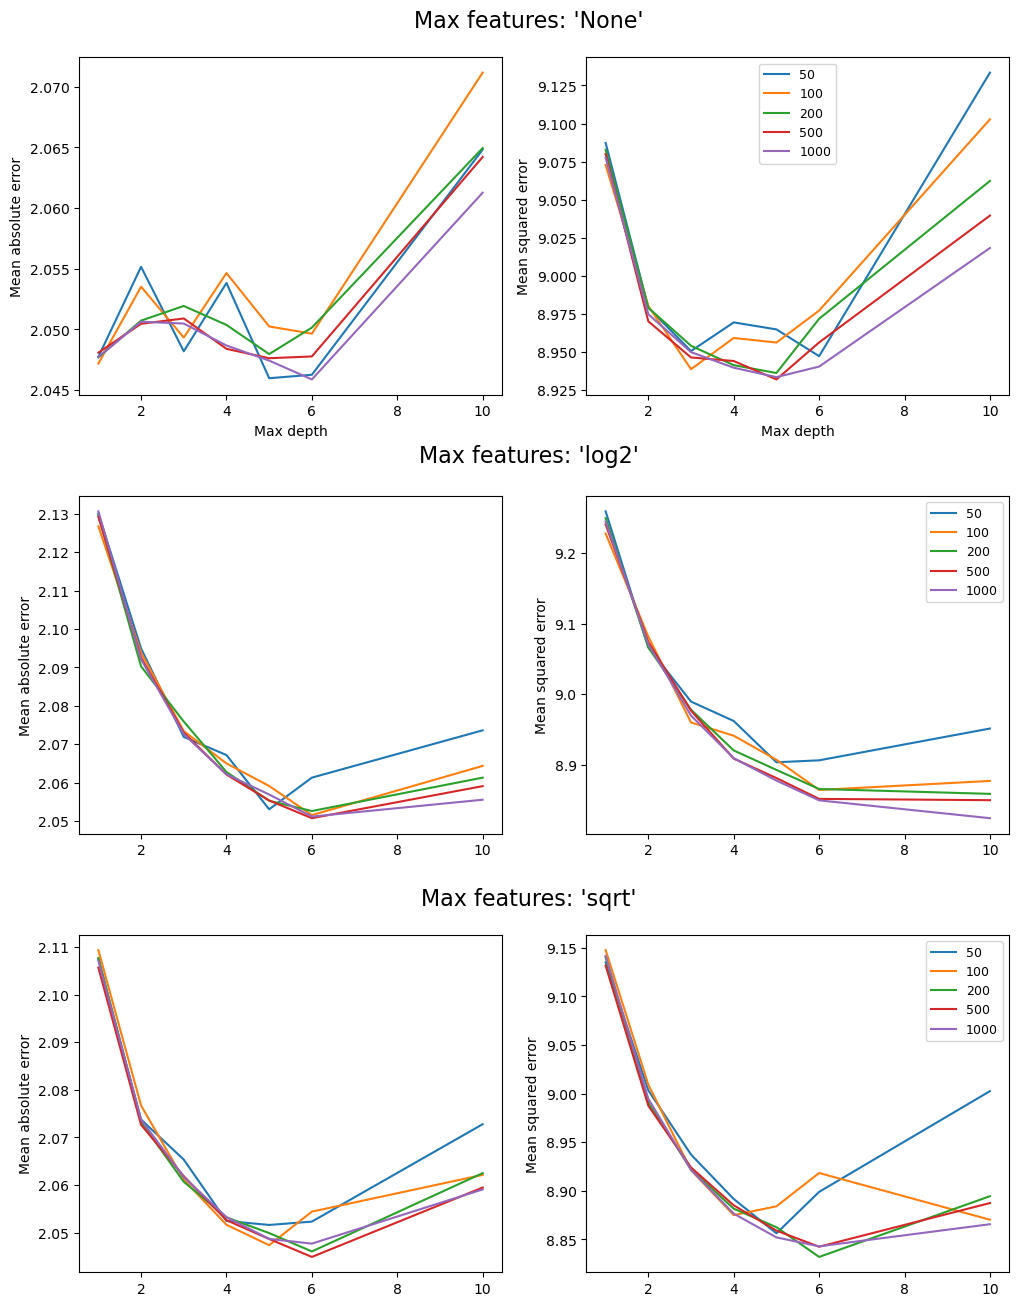

In [177]:
cv_results = rf_mid_cv_results.cv_results_

fig, axs = plt.subplots(3, 2, figsize=(12, 15))
fig.subplots_adjust(hspace=0.3, top=0.92)

for i, max_features in enumerate(rf_mid_param_grid['max_features']):
    for n in rf_mid_param_grid['n_estimators']:
        data_idx_bool = ((cv_results['param_max_features'] == max_features) & (cv_results['param_n_estimators'] == n))
        depth_data = cv_results['param_max_depth'][data_idx_bool]
        
        mae_data = -1*cv_results['mean_test_neg_mean_absolute_error'][data_idx_bool]
        # mae_error_data = cv_results['std_test_neg_mean_absolute_error'][data_idx_bool]
        
        mse_data = -1*cv_results['mean_test_neg_mean_squared_error'][data_idx_bool]
        # mse_error_data = cv_results['std_test_neg_mean_squared_error'][data_idx_bool]
        
        axs[i, 0].plot(depth_data, mae_data, label=f"{n}")
        axs[i, 1].plot(depth_data, mse_data, label=f"{n}")
        
        axs[i, 0].set_ylabel("Mean absolute error")
        axs[i, 1].set_ylabel("Mean squared error")
    
axs[0, 0].set_xlabel("Max depth")
axs[0, 1].set_xlabel("Max depth")

# Add title and subtitles to figure
fig.text(0.5, 0.94, 
         f"Max features: '{rf_mid_param_grid['max_features'][0]}'", 
         fontsize=16, 
         horizontalalignment='center')
fig.text(0.5, 0.65, 
         f"Max features: '{rf_mid_param_grid['max_features'][1]}'", 
         fontsize=16, 
         horizontalalignment='center')
fig.text(0.5, 0.355, 
         f"Max features: '{rf_mid_param_grid['max_features'][2]}'", 
         fontsize=16, 
         horizontalalignment='center')

# Add legends to axes
axs[0, 1].legend(fontsize=9)
axs[1, 1].legend(fontsize=9)
axs[2, 1].legend(fontsize=9)

plt.show()

In [113]:
# # Fit the random forest regression model with hyperparameters as determined above
# max_depth_final = 4
# n_estimators_final = 1000
# rf_mid_model1 = RandomForestRegressor(max_depth=max_depth_final, random_state=0, oob_score=True, n_estimators=n_estimators_final)
# rf_mid_model1.fit(X_train_mid1, y_train_mid)

# rf1_mid_predict_train = rf_mid_model1.predict(X_train_mid1)
# rf1_mid_predict_test = rf_mid_model1.predict(X_test_mid1)

# rf1_mid_resid_train = rf1_mid_predict_train - y_train_mid
# rf1_mid_resid_test = rf1_mid_predict_test - y_test_mid

# rf1_mid_train_mae = np.mean(abs(resid_train))
# rf1_mid_test_mae = np.mean(abs(resid_test))
# rf1_mid_train_mse = np.mean(resid_train**2)
# rf1_mid_test_mse = np.mean(resid_test**2)

# print("MAE on test set = {}\nMSE on test set = {}".format(rf1_mid_test_mae, rf1_mid_test_mse))

In [114]:
# # Examine feature importance
# feature_importances = (pd.Series(rf_mid_model1.feature_importances_, index=X_train_mid1.columns)
#                        .sort_values()
#                        .to_frame(name='importance'))
# feature_importances['rank'] = feature_importances.importance.rank(ascending=False)
# fig, ax = plt.subplots(figsize=(8, 52))
# ax.margins(y = 0.0025)
# ax.barh(feature_importances.index, feature_importances.importance)
# plt.show()

In [115]:
# importance_threshold = 0.005
# rf_vars_initial = feature_importances.loc[feature_importances.importance >= importance_threshold].index.tolist()
# n_vars = len(rf_vars_initial)
# print("No. of variables = {}".format(len(feature_importances)))
# print("No. of variables above importance threshold = {}".format(len(rf_vars_initial)))

In [116]:
# # We will only perform the variable selection CV using variables that are above the importance threshold in the initial model
# # since running this for all variables would be time-consuming although theoretically preferred.

# # Set up the variable selection cross-validation
# validation_sets = split(X_train_mid1.index, 10)
# max_depth = 4
# n_estimators_list = [1000]
# cv_info = {n: {} for n in n_estimators_list}

# for n_estimators in n_estimators_list:
#     Z_train = X_train_mid1[rf_vars_initial]
#     Z_test = X_test_mid1[rf_vars_initial]
#     rf_vars_current = rf_vars_initial.copy()
#     cv_info[n_estimators] = {x: {} for x in range(1, len(rf_vars_initial)+1)}

#     while len(rf_vars_current) > 0: 
#         print(len(rf_vars_current))
#         cv_info[n_estimators][len(rf_vars_current)]['vars'] = rf_vars_current.copy()

#         Z_train = Z_train[rf_vars_current]
#         rf_regr_vs = RandomForestRegressor(max_depth=max_depth,
#                                             random_state=0,
#                                             oob_score=True,
#                                             n_estimators=n_estimators)
#         rf_regr_vs.fit(Z_train, y_train_mid)

#         # Get MAE and MSE estimates using cross-validation
#         mae = []
#         mse = []
#         for validation_idxs in validation_sets:
#             Z_train1 = Z_train.drop(validation_idxs, axis=0)
#             y_train_mid1 = y_train_mid.drop(validation_idxs)
#             Z_val = Z_train.loc[validation_idxs]
#             y_val_mid = y_train_mid.loc[validation_idxs]

#             rf_regr = RandomForestRegressor(max_depth=max_depth,
#                                             random_state=0,
#                                             oob_score=True,
#                                             n_estimators=n_estimators)
#             rf_regr.fit(Z_train1, y_train_mid1)

#             predict_val = rf_regr.predict(Z_val)
#             resid_val = predict_val - y_val_mid
#             mae.append(np.mean(abs(resid_val)))
#             mse.append(np.mean(resid_val**2))

#         cv_info[n_estimators][len(rf_vars_current)]['mae'] = np.mean(mae)
#         cv_info[n_estimators][len(rf_vars_current)]['mse'] = np.mean(mse)

#         var_importances = pd.Series(rf_regr_vs.feature_importances_, index=rf_vars_current).sort_values()
#         drop_var = var_importances.index[0]
#         rf_vars_current.remove(var_importances.index[0])

    

In [117]:
# idx = np.linspace(1, n_vars, n_vars)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# for n_estimators in n_estimators_list:
#     mae_varselect_cv = [cv_info[n_estimators][x]['mae'] for x in cv_info[n_estimators]]
#     mse_varselect_cv = [cv_info[n_estimators][x]['mse'] for x in cv_info[n_estimators]]
    
#     ax1.plot(idx, mae_varselect_cv, label="{}".format(n_estimators))
#     ax2.plot(idx, mse_varselect_cv, label="{}".format(n_estimators))
    
# ax1.set_xlabel("No. of variables")
# ax1.set_ylabel("Validation MAE")
# ax1.legend()
# ax2.set_xlabel("No. of variables")
# ax2.set_ylabel("Validation MSE")
# ax2.legend()

# plt.show()

In [118]:
# # Fit the model after selecting variables
# n_estimators_final = 1000
# n_vars_final = 22
# mid_rf_vars_final = cv_info[n_estimators_final][n_vars_final]['vars']
# X_train_mid_rf = X_train_mid1[mid_rf_vars_final]
# X_test_mid_rf = X_test_mid1[mid_rf_vars_final]

# rf_mid_model2 = RandomForestRegressor(max_depth=4, oob_score=True, n_estimators=n_estimators_final)
# rf_mid_model2.fit(X_train_mid_rf, y_train_mid)

# rf2_mid_test_predict = rf_mid_model2.predict(X_test_mid_rf)
# rf2_mid_test_resid = rf2_mid_test_predict - y_test_mid
# rf2_mid_test_mae = np.mean(abs(rf2_mid_test_resid))
# rf2_mid_test_mse = np.mean(rf2_mid_test_resid**2)
# print("MAE on test set = {:.3f}\nMSE on test set = {:.3f}".format(rf2_mid_test_mae, rf2_mid_test_mse))

# 6 Forward modelling

In [119]:
# Drop highly correlated columns
drop_cols = (["opp_npxGA_{}".format(x) for x in range(1, 5)] +
             ["opp_npxG_{}".format(x) for x in range(1, 5)] + 
             ["team_npxG_{}".format(x) for x in range(1, 5)] + 
             ["team_npxGA_{}".format(x) for x in range(1, 5)] +
             ["selected_{}".format(x) for x in range(1, 5)] + 
             ["value_{}".format(x) for x in range(1, 5)] + 
             ["npxG_{}".format(x) for x in range(1, 5)] + 
             ["npg_{}".format(x) for x in range(1, 5)] + 
             ["starts_{}".format(x) for x in range(1, 5)] + 
             ["influence_{}".format(x) for x in range(1, 5)] + 
             ["creativity_{}".format(x) for x in range(1, 5)] + 
             ["bps_{}".format(x) for x in range(1, 5)]
             )

X_train_fwd2 = X_train_fwd1.drop(drop_cols, axis=1)
X_test_fwd2 = X_test_fwd1.drop(drop_cols, axis=1)

## 6.1 Ordinary Least Squares

In [120]:
# Fit an initial linear model to the training data
ols_model_fwd = sm.OLS(y_train_fwd, X_train_fwd2)
ols_res_fwd = ols_model_fwd.fit()

ols_fwd_resid = ols_res_fwd.resid_pearson
ols_fwd_fv = ols_res_fwd.fittedvalues

The QQ plot of standardised residuals vs the theoretical quantiles appears to show significant skew in the distribution of residuals. Much like the plot for the goalkeepers, the plot of standardised residuals appears to indicate heteroskedasticity in the standardised residuals, with smaller variance in residuals for lower fitted values.

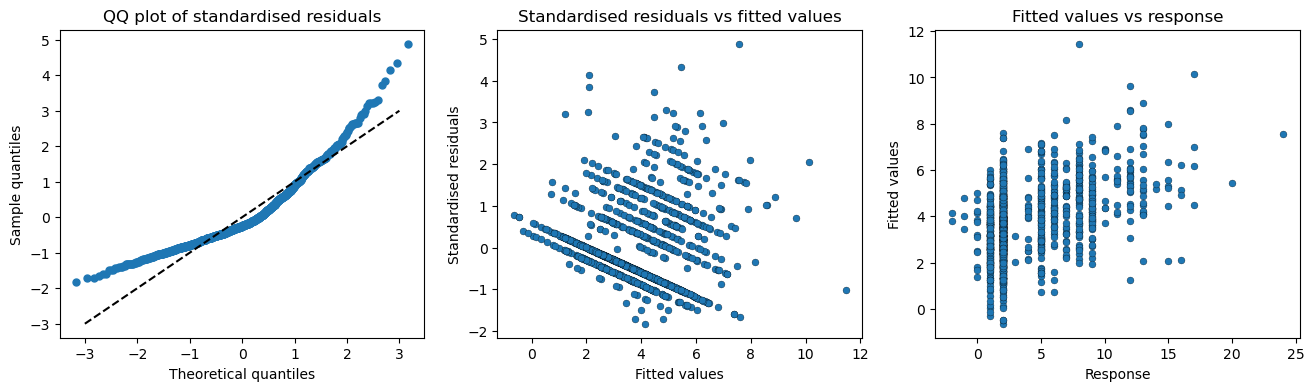

In [121]:
gof_plots(y_train_fwd, ols_fwd_resid, ols_fwd_fv)

I now want to apply the model to the test data in order to assess its performance. As a baseline model I will use the average value from the training data and assign this as the predicted value for all test set data. Then, we can compare the performance of future models against this uninformed model.

In [122]:
# Compute the test MAE and MSE under the use of the training mean as a constant model
fwd_baseline_mae = np.mean(abs(y_train_fwd.mean() - y_test_fwd))
fwd_baseline_mse = np.mean((y_train_fwd.mean() - y_test_fwd)**2)
print("MAE: {:.3f}\nMSE: {:.3f}".format(fwd_baseline_mae, fwd_baseline_mse))

MAE: 3.063
MSE: 15.964


In [123]:
# Get predicted values for the test data
X_test_fwd2 = X_test_fwd1[X_train_fwd2.columns]
ols_fwd_test_predict = ols_res_fwd.predict(X_test_fwd2)
ols_fwd_test_resid = ols_fwd_test_predict - y_test_fwd

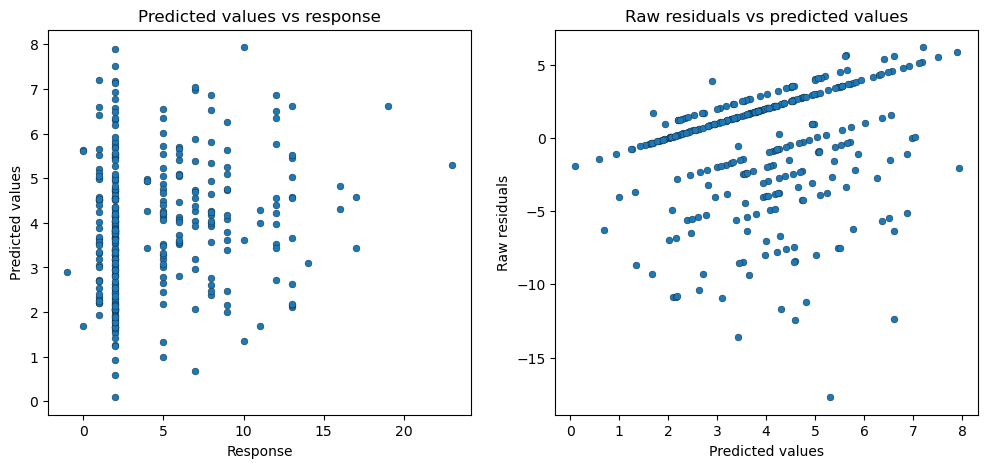

In [124]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot of predicted values vs actual values
ax1.scatter(y_test_fwd, ols_fwd_test_predict, edgecolor='k', linewidths=0.2)
ax1.set_xlabel("Response")
ax1.set_ylabel("Predicted values")
ax1.set_title("Predicted values vs response")

# Plot of residuals vs fitted values
ax2.scatter(ols_fwd_test_predict, ols_fwd_test_resid, edgecolor='k', linewidths=0.2)
ax2.set_xlabel("Predicted values")
ax2.set_ylabel("Raw residuals")
ax2.set_title("Raw residuals vs predicted values")

plt.show()

In [125]:
# Compute test MAE and MSE
ols_fwd_test_mae = np.mean(abs(ols_fwd_test_resid))
ols_fwd_test_mse = np.mean(ols_fwd_test_resid**2)
print("MAE: {:.3f}\nMSE: {:.3f}".format(ols_fwd_test_mae, ols_fwd_test_mse))

MAE: 2.951
MSE: 16.050


In [126]:
shift = 1
y_train_fwd_boxcox = y_train_fwd.drop(y_train_fwd.loc[y_train_fwd < 0].index) + shift
y_train_fwd_boxcox_index = y_train_fwd_boxcox.index
X_train_fwd_boxcox = X_train_fwd2.drop(y_train_fwd.loc[y_train_fwd < 0].index)

y_train_fwd_boxcox, lambda_fwd = stats.boxcox(y_train_fwd_boxcox)

y_train_fwd_boxcox = pd.Series(y_train_fwd_boxcox, y_train_fwd_boxcox_index)

In [127]:
# Perform stepwise backward elimination, removing variables whose coefficient estimates do not have p-values falling below
# the specified threshold
priority_list_fwd = priority_list.copy()
dropped_cols = []
X_train_fwd_temp = X_train_fwd_boxcox.copy()
selection_complete = False
p_value_threshold = 0.1

while not selection_complete:
    model_temp = sm.OLS(y_train_fwd_boxcox, X_train_fwd_temp)
    res_temp = model_temp.fit()
    drop_candidates = res_temp.pvalues.loc[res_temp.pvalues > p_value_threshold]
    if len(drop_candidates) == 0:
        selection_complete = True
        continue
    
    drop_col = priority_list_fwd.pop([col in drop_candidates for col in priority_list_fwd].index(True))
    dropped_cols.append(drop_col)
    X_train_fwd_temp.drop(drop_col, axis=1, inplace=True)

In [128]:
# Examine model chosen by backward elimination
X_train_fwd_bs = sm.add_constant(X_train_fwd_temp)
ols_bs_model_fwd = sm.OLS(y_train_fwd_boxcox, X_train_fwd_bs)
ols_bs_res_fwd = ols_bs_model_fwd.fit()

print(ols_bs_res_fwd.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     6.048
Date:                Sat, 13 Apr 2024   Prob (F-statistic):           5.10e-13
Time:                        14:32:03   Log-Likelihood:                -100.72
No. Observations:                1271   AIC:                             235.4
Df Residuals:                    1254   BIC:                             322.9
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.9379      0

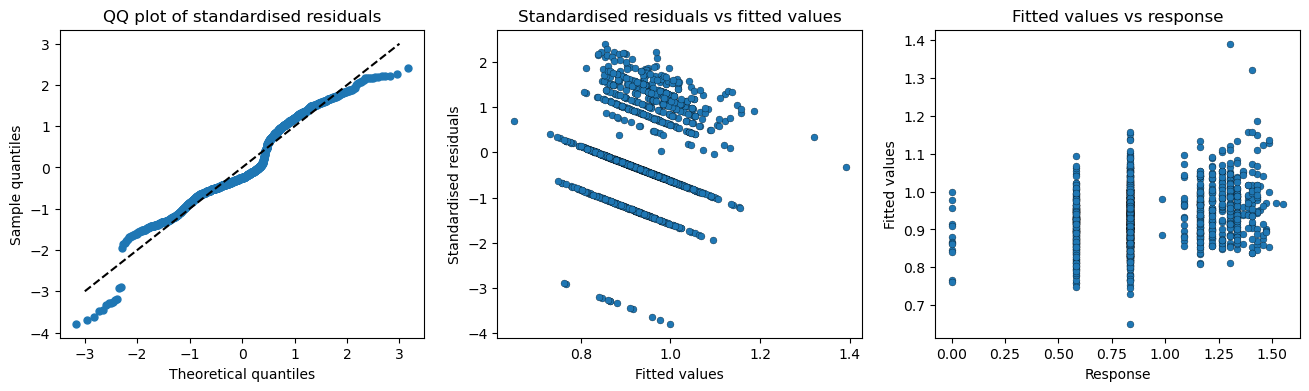

In [129]:
ols_bs_fwd_resid = ols_bs_res_fwd.resid_pearson
ols_bs_fwd_fv = ols_bs_res_fwd.fittedvalues

gof_plots(y_train_fwd_boxcox, ols_bs_fwd_resid, ols_bs_fwd_fv)

The above diagnostic plots show that there has been an improvement in the specification of the model as a result of the transformation of the response variable and the application of the backward elimination variable selection process. The QQ plot indicates that the standardised residuals more closely fit the standard normal distribution; the plot of standardised residuals vs fitted values shows a decrease in clear heteroskedasticity in the residuals; and, although the fitted values vs response plot shows an increase in variablility, this is likely due to overfitting in the previous model.

In [130]:
# Apply the backward selection model to the test data
X_test_fwd_bs = X_test_fwd1[X_train_fwd_bs.columns]

# Apply inverse Box-Cox transformation to the predicted values
ols_bs_fwd_test_predict_boxcox = ols_bs_res_fwd.predict(X_test_fwd_bs)
ols_bs_fwd_test_predict = inverse_boxcox(ols_bs_fwd_test_predict_boxcox, lmbda=lambda_fwd) - 1

ols_bs_fwd_test_resid = ols_bs_fwd_test_predict - y_test_fwd

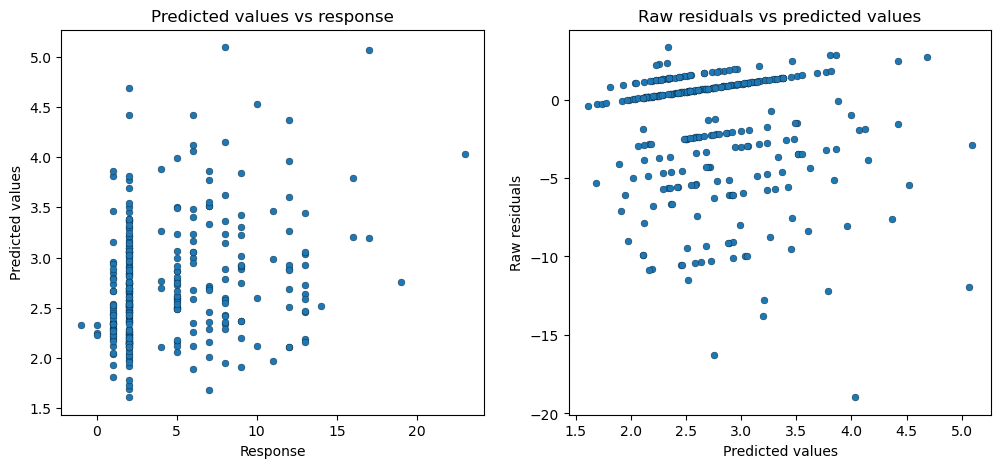

In [131]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot of predicted values vs actual values
ax1.scatter(y_test_fwd, ols_bs_fwd_test_predict, edgecolor='k', linewidths=0.2)
ax1.set_xlabel("Response")
ax1.set_ylabel("Predicted values")
ax1.set_title("Predicted values vs response")

# Plot of residuals vs fitted values
ax2.scatter(ols_bs_fwd_test_predict, ols_bs_fwd_test_resid, edgecolor='k', linewidths=0.2)
ax2.set_xlabel("Predicted values")
ax2.set_ylabel("Raw residuals")
ax2.set_title("Raw residuals vs predicted values")

plt.show()

In [132]:
# Compute OOS MAE and MSE
mae_bs = np.mean(abs(ols_bs_fwd_test_resid))
mse_bs = np.mean(ols_bs_fwd_test_resid**2)
print("MAE: {:.3f}\nMSE: {:.3f}".format(mae_bs, mse_bs))

MAE: 2.756
MSE: 17.566


## 6.2 Lasso Regression

We now move on to fitting penalised regressions in order to select important variables. We begin by performing a cross-validation to determine the optimal order of magnitude for the penalisation parameter. For both the lasso and ridge regressions we continue to fit the linear model to the response after having applied the Box-Cox transform as above.

In [133]:
# Run a lasso regression implementing 10-fold cross-validation for the selection of the tuning parameter
validation_idxs = split(X_train_fwd_boxcox.sample(frac=1).index, 10)
lasso_fwd_alpha_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
lasso_fwd_cv_error_dict = {'mae': [], 'mse': []}
for a in lasso_fwd_alpha_list:
    mae = []
    mse = []
    
    for i, idx in enumerate(validation_idxs):
        X_val_fwd_cv = X_train_fwd_boxcox.loc[idx]
        y_val_fwd_cv = y_train_fwd[idx]
        X_train_fwd_cv = X_train_fwd_boxcox.drop(idx, axis=0)
        y_train_fwd_cv = y_train_fwd_boxcox.drop(idx)
        
        lasso_fwd_model = sm.OLS(y_train_fwd_cv, X_train_fwd_cv)
        lasso_fwd_res = lasso_fwd_model.fit_regularized(alpha=a, L1_wt=1)
        
        lasso_fwd_cv_predict_boxcox = lasso_fwd_res.predict(X_val_fwd_cv)
        lasso_fwd_cv_predict = inverse_boxcox(lasso_fwd_cv_predict_boxcox, lmbda=lambda_fwd) - 1
        
        mae.append(np.mean(abs(lasso_fwd_cv_predict - y_val_fwd_cv)))
        mse.append(np.mean((lasso_fwd_cv_predict - y_val_fwd_cv)**2))
        
    lasso_fwd_cv_error_dict['mae'].append(np.mean(mae))
    lasso_fwd_cv_error_dict['mse'].append(np.mean(mse))

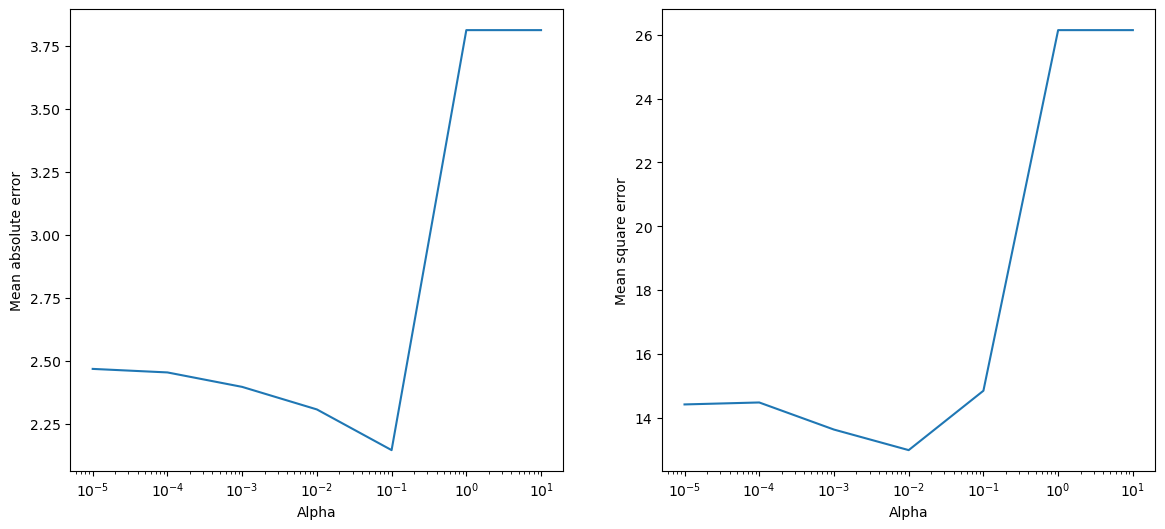

In [134]:
# Plot the MAE and MSE for different values of the tuning parameters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(lasso_fwd_alpha_list, lasso_fwd_cv_error_dict['mae'])
ax1.set_xscale("log")
ax1.set_xlabel("Alpha")
ax1.set_ylabel("Mean absolute error")

ax2.plot(lasso_fwd_alpha_list, lasso_fwd_cv_error_dict['mse'])
ax2.set_xscale("log")
ax2.set_xlabel("Alpha")
ax2.set_ylabel("Mean square error")

plt.show()

The plots above indicate that the best two options for the penalisation parameter, `alpha`, would be 0.1, which minimizes the mean absolute error, or 0.01, which minimizes the mean square error. Note that, here, the larger the size of the parameter the stricter the penalisation of the regression coefficients. I have chosen to use `alpha` = 0.01 as the minimizer of the mean square error on the validation sets.

In [135]:
# Fit the final lasso model
lasso_fwd_alpha = 1e-2

lasso_fwd_model = sm.OLS(y_train_fwd_boxcox, X_train_fwd_boxcox)
lasso_fwd_res = lasso_fwd_model.fit_regularized(alpha=lasso_fwd_alpha, L1_wt=1)

In [136]:
# Predict the response on the test set
lasso_fwd_test_predict_boxcox = lasso_fwd_res.predict(X_test_fwd2)
lasso_fwd_test_predict = inverse_boxcox(lasso_fwd_test_predict_boxcox, lmbda=lambda_fwd)
lasso_fwd_test_resid = lasso_fwd_test_predict - y_test_fwd

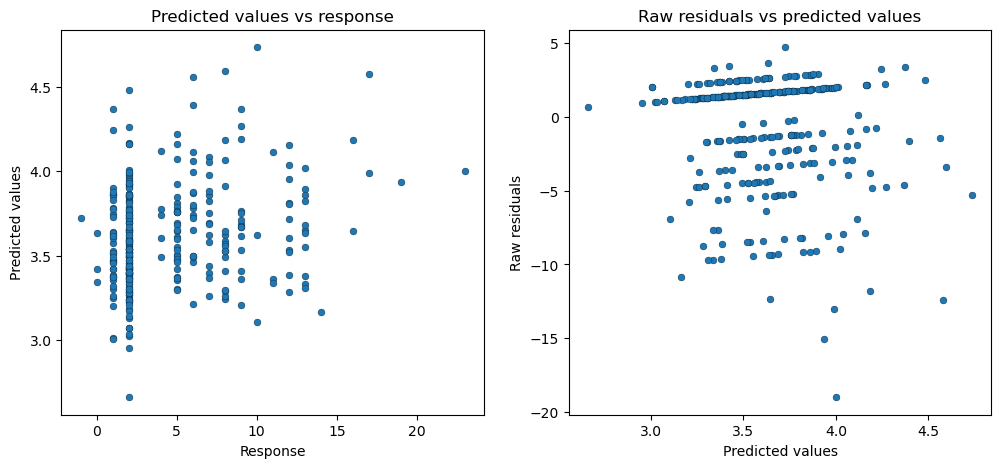

In [137]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot of predicted values vs actual values
ax1.scatter(y_test_fwd, lasso_fwd_test_predict, edgecolor='k', linewidths=0.2)
ax1.set_xlabel("Response")
ax1.set_ylabel("Predicted values")
ax1.set_title("Predicted values vs response")

# Plot of residuals vs fitted values
ax2.scatter(lasso_fwd_test_predict, lasso_fwd_test_resid, edgecolor='k', linewidths=0.2)
ax2.set_xlabel("Predicted values")
ax2.set_ylabel("Raw residuals")
ax2.set_title("Raw residuals vs predicted values")

plt.show()

In [138]:
# Compute OOS MAE and MSE
lasso_fwd_mae = np.mean(abs(lasso_fwd_test_resid))
lasso_fwd_mse = np.mean(lasso_fwd_test_resid**2)
print("MAE: {:.3f}\nMSE: {:.3f}".format(lasso_fwd_mae, lasso_fwd_mse))

MAE: 2.961
MSE: 15.739


## 6.3 Ridge Regression

In [139]:
# Run a ridge regression implementing 10-fold cross-validation for the selection of the tuning parameter
ridge_fwd_alpha_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
ridge_fwd_cv_error_dict = {'mae': [], 'mse': []}
for a in ridge_fwd_alpha_list:
    mae = []
    mse = []
    
    for i, idx in enumerate(validation_idxs):
        X_val_fwd_cv = X_train_fwd_boxcox.loc[idx]
        y_val_fwd_cv = y_train_fwd[idx]
        X_train_fwd_cv = X_train_fwd_boxcox.drop(idx, axis=0)
        y_train_fwd_cv = y_train_fwd_boxcox.drop(idx)
        
        ridge_fwd_model = sm.OLS(y_train_fwd_cv, X_train_fwd_cv)
        ridge_fwd_res = ridge_fwd_model.fit_regularized(alpha=a, L1_wt=0)
        
        ridge_fwd_cv_predict_boxcox = ridge_fwd_res.predict(X_val_fwd_cv)
        ridge_fwd_cv_predict = inverse_boxcox(ridge_fwd_cv_predict_boxcox, lmbda=lambda_fwd) - 1
        
        mae.append(np.mean(abs(ridge_fwd_cv_predict - y_val_fwd_cv)))
        mse.append(np.mean((ridge_fwd_cv_predict - y_val_fwd_cv)**2))
        
    ridge_fwd_cv_error_dict['mae'].append(np.mean(mae))
    ridge_fwd_cv_error_dict['mse'].append(np.mean(mse))

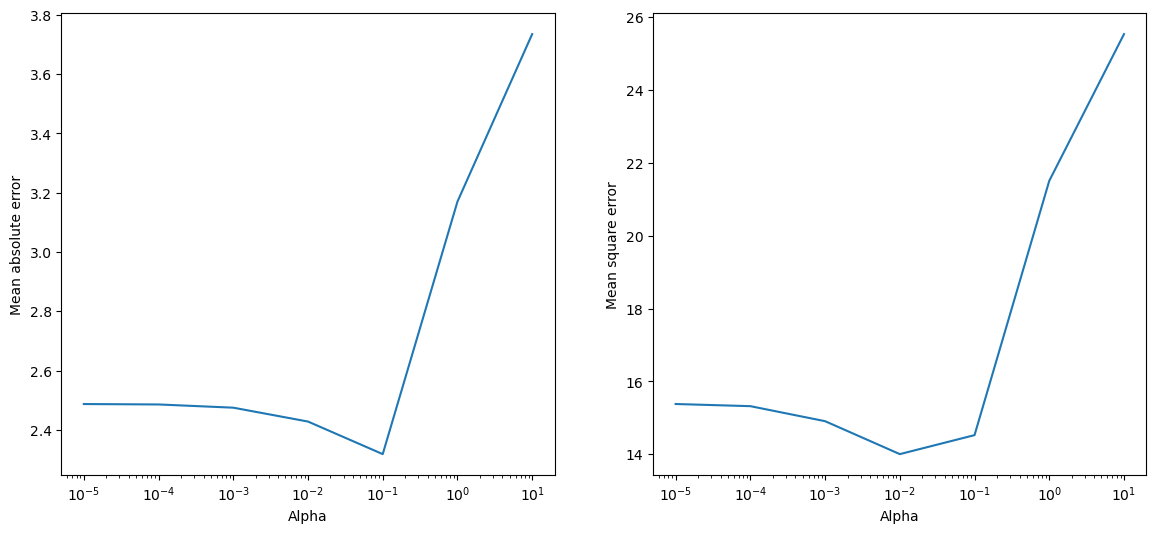

In [140]:
# Plot the MAE and MSE on the validation sets for different values of the tuning parameters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(ridge_fwd_alpha_list, ridge_fwd_cv_error_dict['mae'])
ax1.set_xscale("log")
ax1.set_xlabel("Alpha")
ax1.set_ylabel("Mean absolute error")

ax2.plot(ridge_fwd_alpha_list, ridge_fwd_cv_error_dict['mse'])
ax2.set_xscale("log")
ax2.set_xlabel("Alpha")
ax2.set_ylabel("Mean square error")

plt.show()

In [141]:
# Fit the final ridge model
ridge_fwd_alpha = 1e-2

ridge_fwd_model = sm.OLS(y_train_fwd_boxcox, X_train_fwd_boxcox)
ridge_fwd_res = ridge_fwd_model.fit_regularized(alpha=ridge_fwd_alpha, L1_wt=0)

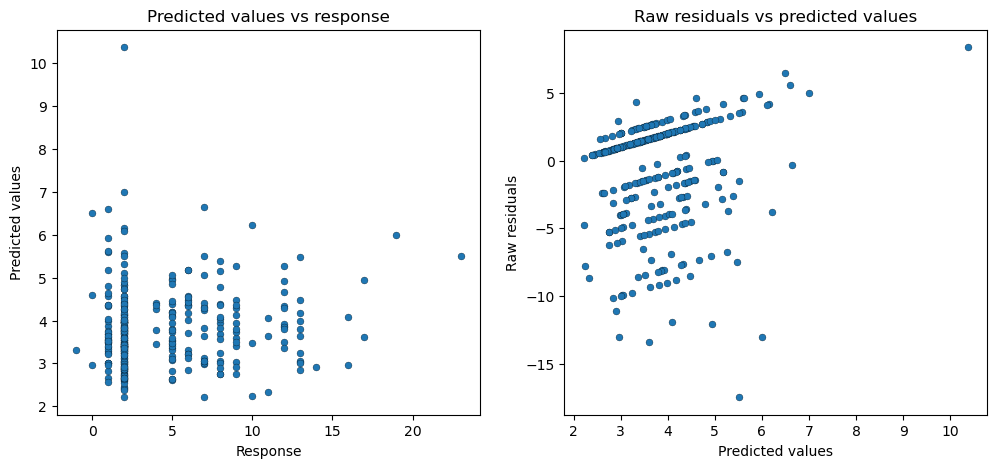

In [142]:
# Predict the response on the test set
ridge_fwd_test_predict_boxcox = ridge_fwd_res.predict(X_test_fwd2)
ridge_fwd_test_predict = inverse_boxcox(ridge_fwd_test_predict_boxcox, lmbda=lambda_fwd)
ridge_fwd_test_resid = ridge_fwd_test_predict - y_test_fwd

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot of predicted values vs actual values
ax1.scatter(y_test_fwd, ridge_fwd_test_predict, edgecolor='k', linewidths=0.2)
ax1.set_xlabel("Response")
ax1.set_ylabel("Predicted values")
ax1.set_title("Predicted values vs response")

# Plot of residuals vs fitted values
ax2.scatter(ridge_fwd_test_predict, ridge_fwd_test_resid, edgecolor='k', linewidths=0.2)
ax2.set_xlabel("Predicted values")
ax2.set_ylabel("Raw residuals")
ax2.set_title("Raw residuals vs predicted values")

plt.show()

In [143]:
# Compute OOS MAE and MSE
ridge_fwd_mae = np.mean(abs(ridge_fwd_test_resid))
ridge_fwd_mse = np.mean(ridge_fwd_test_resid**2)
print("MAE: {:.3f}\nMSE: {:.3f}".format(ridge_fwd_mae, ridge_fwd_mse))

MAE: 2.987
MSE: 16.079


## 6.4 Random Forest Regression

In [173]:
# Conduct 10-fold cross-validation on the parameter grid to select hyperparameters for the random forest
rf_fwd_param_grid = {'max_depth': [1, 2, 3, 4, 5, 6, 10],
                    'n_estimators': [100, 200, 500, 1000, 1500],
                    'max_features': [None, 'log2', 'sqrt']}
scoring_metrics = ['neg_mean_absolute_error', 'neg_mean_squared_error']
rf_fwd_cv_results = GridSearchCV(RandomForestRegressor(), 
                                rf_fwd_param_grid, 
                                scoring=scoring_metrics,
                                cv=10,
                                refit=False)
rf_fwd_cv_results.fit(X_train_fwd1, y_train_fwd)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 10],
                         'max_features': [None, 'log2', 'sqrt'],
                         'n_estimators': [100, 200, 500, 1000, 1500]},
             refit=False,
             scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'])

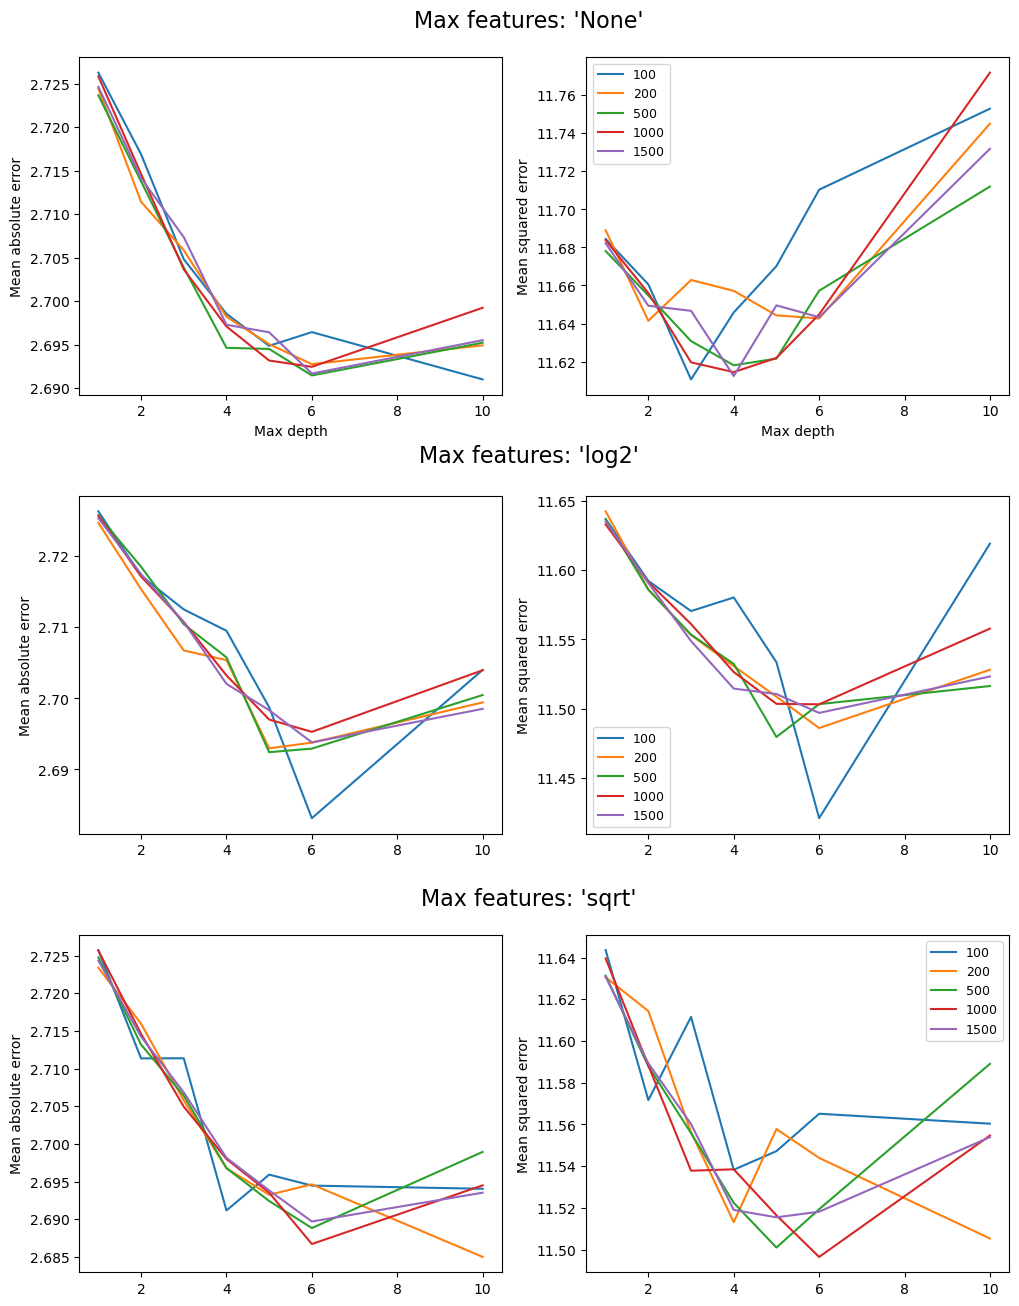

In [178]:
cv_results = rf_fwd_cv_results.cv_results_

fig, axs = plt.subplots(3, 2, figsize=(12, 15))
fig.subplots_adjust(hspace=0.3, top=0.92)

for i, max_features in enumerate(rf_fwd_param_grid['max_features']):
    for n in rf_fwd_param_grid['n_estimators']:
        data_idx_bool = ((cv_results['param_max_features'] == max_features) & (cv_results['param_n_estimators'] == n))
        depth_data = cv_results['param_max_depth'][data_idx_bool]
        
        mae_data = -1*cv_results['mean_test_neg_mean_absolute_error'][data_idx_bool]
        # mae_error_data = cv_results['std_test_neg_mean_absolute_error'][data_idx_bool]
        
        mse_data = -1*cv_results['mean_test_neg_mean_squared_error'][data_idx_bool]
        # mse_error_data = cv_results['std_test_neg_mean_squared_error'][data_idx_bool]
        
        axs[i, 0].plot(depth_data, mae_data, label=f"{n}")
        axs[i, 1].plot(depth_data, mse_data, label=f"{n}")
        
        axs[i, 0].set_ylabel("Mean absolute error")
        axs[i, 1].set_ylabel("Mean squared error")
    
axs[0, 0].set_xlabel("Max depth")
axs[0, 1].set_xlabel("Max depth")

# Add title and subtitles to figure
fig.text(0.5, 0.94, 
         f"Max features: '{rf_fwd_param_grid['max_features'][0]}'", 
         fontsize=16, 
         horizontalalignment='center')
fig.text(0.5, 0.65, 
         f"Max features: '{rf_fwd_param_grid['max_features'][1]}'", 
         fontsize=16, 
         horizontalalignment='center')
fig.text(0.5, 0.355, 
         f"Max features: '{rf_fwd_param_grid['max_features'][2]}'", 
         fontsize=16, 
         horizontalalignment='center')

# Add legends to axes
axs[0, 1].legend(fontsize=9)
axs[1, 1].legend(fontsize=9)
axs[2, 1].legend(fontsize=9)

plt.show()

In [147]:
# # Fit the random forest regression model with hyperparameters as determined above
# max_depth_final = 4
# n_estimators_final = 1000
# rf_fwd_model1 = RandomForestRegressor(max_depth=max_depth_final, random_state=0, oob_score=True, n_estimators=n_estimators_final)
# rf_fwd_model1.fit(X_train_fwd1, y_train_fwd)

# rf1_fwd_predict_train = rf_fwd_model1.predict(X_train_fwd1)
# rf1_fwd_predict_test = rf_fwd_model1.predict(X_test_fwd1)

# rf1_fwd_resid_train = rf1_fwd_predict_train - y_train_fwd
# rf1_fwd_resid_test = rf1_fwd_predict_test - y_test_fwd

# rf1_fwd_train_mae = np.mean(abs(resid_train))
# rf1_fwd_test_mae = np.mean(abs(resid_test))
# rf1_fwd_train_mse = np.mean(resid_train**2)
# rf1_fwd_test_mse = np.mean(resid_test**2)

# print("MAE on test set = {}\nMSE on test set = {}".format(rf1_fwd_test_mae, rf1_fwd_test_mse))

In [148]:
# # Examine feature importance
# feature_importances = (pd.Series(rf_fwd_model1.feature_importances_, index=X_train_fwd1.columns)
#                        .sort_values()
#                        .to_frame(name='importance'))
# feature_importances['rank'] = feature_importances.importance.rank(ascending=False)
# fig, ax = plt.subplots(figsize=(8, 52))
# ax.margins(y = 0.0025)
# ax.barh(feature_importances.index, feature_importances.importance)
# plt.show()

In [149]:
# importance_threshold = 0.005
# rf_vars_initial = feature_importances.loc[feature_importances.importance >= importance_threshold].index.tolist()
# n_vars = len(rf_vars_initial)
# print("No. of variables = {}".format(len(feature_importances)))
# print("No. of variables above importance threshold = {}".format(len(rf_vars_initial)))

In [150]:
# # We will only perform the variable selection CV using variables that are above the importance threshold in the initial model
# # since running this for all variables would be time-consuming although theoretically preferred.

# # Set up the variable selection cross-validation
# validation_sets = split(X_train_fwd1.index, 10)
# max_depth = 4
# n_estimators_list = [1000]
# cv_info = {n: {} for n in n_estimators_list}

# for n_estimators in n_estimators_list:
#     Z_train = X_train_fwd1[rf_vars_initial]
#     Z_test = X_test_fwd1[rf_vars_initial]
#     rf_vars_current = rf_vars_initial.copy()
#     cv_info[n_estimators] = {x: {} for x in range(1, len(rf_vars_initial)+1)}

#     while len(rf_vars_current) > 0: 
#         print(len(rf_vars_current))
#         cv_info[n_estimators][len(rf_vars_current)]['vars'] = rf_vars_current.copy()

#         Z_train = Z_train[rf_vars_current]
#         rf_regr_vs = RandomForestRegressor(max_depth=max_depth,
#                                             random_state=0,
#                                             oob_score=True,
#                                             n_estimators=n_estimators)
#         rf_regr_vs.fit(Z_train, y_train_fwd)

#         # Get MAE and MSE estimates using cross-validation
#         mae = []
#         mse = []
#         for validation_idxs in validation_sets:
#             Z_train1 = Z_train.drop(validation_idxs, axis=0)
#             y_train_fwd1 = y_train_fwd.drop(validation_idxs)
#             Z_val = Z_train.loc[validation_idxs]
#             y_val_fwd = y_train_fwd.loc[validation_idxs]

#             rf_regr = RandomForestRegressor(max_depth=max_depth,
#                                             random_state=0,
#                                             oob_score=True,
#                                             n_estimators=n_estimators)
#             rf_regr.fit(Z_train1, y_train_fwd1)

#             predict_val = rf_regr.predict(Z_val)
#             resid_val = predict_val - y_val_fwd
#             mae.append(np.mean(abs(resid_val)))
#             mse.append(np.mean(resid_val**2))

#         cv_info[n_estimators][len(rf_vars_current)]['mae'] = np.mean(mae)
#         cv_info[n_estimators][len(rf_vars_current)]['mse'] = np.mean(mse)

#         var_importances = pd.Series(rf_regr_vs.feature_importances_, index=rf_vars_current).sort_values()
#         drop_var = var_importances.index[0]
#         rf_vars_current.remove(var_importances.index[0])

    

In [151]:
# idx = np.linspace(1, n_vars, n_vars)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# for n_estimators in n_estimators_list:
#     mae_varselect_cv = [cv_info[n_estimators][x]['mae'] for x in cv_info[n_estimators]]
#     mse_varselect_cv = [cv_info[n_estimators][x]['mse'] for x in cv_info[n_estimators]]
    
#     ax1.plot(idx, mae_varselect_cv, label="{}".format(n_estimators))
#     ax2.plot(idx, mse_varselect_cv, label="{}".format(n_estimators))
    
# ax1.set_xlabel("No. of variables")
# ax1.set_ylabel("Validation MAE")
# ax1.legend()
# ax2.set_xlabel("No. of variables")
# ax2.set_ylabel("Validation MSE")
# ax2.legend()

# plt.show()

In [152]:
# # Fit the model after selecting variables
# n_estimators_final = 1000
# n_vars_final = 22
# fwd_rf_vars_final = cv_info[n_estimators_final][n_vars_final]['vars']
# X_train_fwd_rf = X_train_fwd1[fwd_rf_vars_final]
# X_test_fwd_rf = X_test_fwd1[fwd_rf_vars_final]

# rf_fwd_model2 = RandomForestRegressor(max_depth=4, oob_score=True, n_estimators=n_estimators_final)
# rf_fwd_model2.fit(X_train_fwd_rf, y_train_fwd)

# rf2_fwd_test_predict = rf_fwd_model2.predict(X_test_fwd_rf)
# rf2_fwd_test_resid = rf2_fwd_test_predict - y_test_fwd
# rf2_fwd_test_mae = np.mean(abs(rf2_fwd_test_resid))
# rf2_fwd_test_mse = np.mean(rf2_fwd_test_resid**2)
# print("MAE on test set = {:.3f}\nMSE on test set = {:.3f}".format(rf2_fwd_test_mae, rf2_fwd_test_mse))